#Technical Indicator based Trading Strategies

In [ ]:
!pip install yfinance
!pip install yahoofinancials
!pip install ta
!pip install optuna
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# display multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import copy

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (15, 8)
plt.rcParams["lines.linewidth"] = 3.0

Loading Nifty 50 data from Yahoo

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-12-31,6105.100098,6147.299805,6103.549805,6134.500000,6134.500000,0
2011-01-03,6177.450195,6178.549805,6147.200195,6157.600098,6157.600098,0
2011-01-04,6172.750000,6181.049805,6124.399902,6146.350098,6146.350098,0


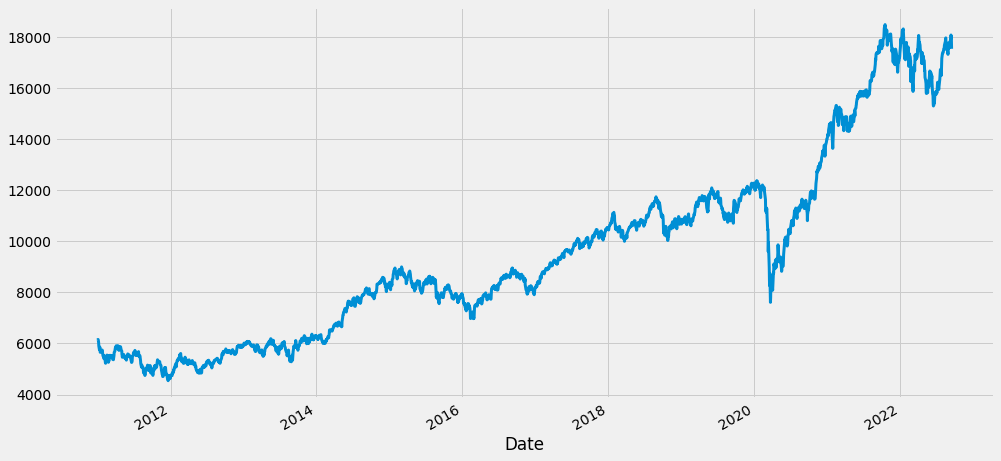

In [ ]:
df = yf.download("^NSEI", start="2010-12-31", end="2022-09-18", progress=False)
df.head(3)
print()
df["Adj Close"].plot()

In [ ]:
tilist, bestnarlist, bestsrlist, bestnarparamlist, bestsrparamlist = [], [], [], [], []

##A. Optimization of Traditional Trading Indicators Parameters

### (1) Simple Moving Average

In [ ]:
from ta.trend import SMAIndicator

niftydf = copy.deepcopy(df)
niftydf["sma20"] = SMAIndicator(close=niftydf["Adj Close"], window=20, fillna=True).sma_indicator()
niftydf["sma50"] = SMAIndicator(close=niftydf["Adj Close"], window=50, fillna=True).sma_indicator()
niftydf["signal"] = np.where(niftydf["sma20"]>niftydf["sma50"], 1, 0)
# niftydf["signal"] = niftydf["signal"].shift(1)
niftydf.dropna(inplace=True)
niftydf["signal"].describe()

count    2868.000000
mean        0.653417
std         0.475965
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: signal, dtype: float64

In [ ]:
niftydf["ROC"] = np.log(niftydf["Adj Close"] / niftydf["Adj Close"].shift(1))
niftydf["return"] = niftydf["ROC"]*niftydf["signal"]
niftydf["portfolio"] = np.exp(niftydf["return"].cumsum())
niftydf.dropna(inplace=True)
niftydf.tail(3)

,Open,High,Low,Close,Adj Close,Volume,sma20,sma50,signal,ROC,return,portfolio
Date,,,,,,,,,,,,
2022-09-14,17771.150391,18091.550781,17771.150391,18003.750000,18003.750000,365900,17707.809961,17115.579961,1,-0.003676,-0.003676,2.341073
2022-09-15,18046.349609,18096.150391,17861.500000,17877.400391,17877.400391,289600,17704.467480,17156.420977,1,-0.007043,-0.007043,2.324643
2022-09-16,17796.800781,17820.050781,17497.250000,17530.849609,17530.849609,468500,17683.184961,17190.820977,1,-0.019575,-0.019575,2.279580


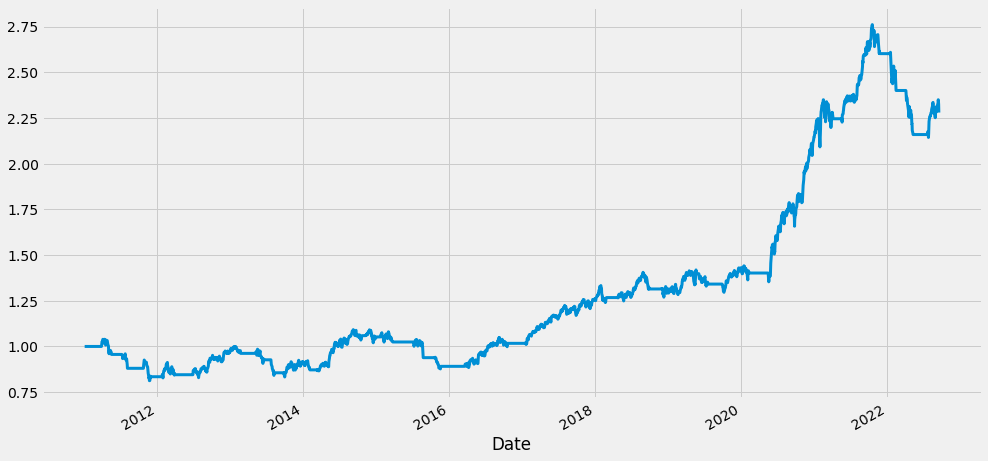

In [ ]:
niftydf["portfolio"].plot()

In [ ]:
duration_days = niftydf.index.max()-niftydf.index.min()
duration_years = duration_days.days/365.25
duration_in_trade = duration_years * niftydf["signal"].mean()
print(f"duration in trade: {duration_in_trade:.4f}")

net_avg_return = niftydf.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
print(f"net average return: {net_avg_return:.4f}")

returns = niftydf[niftydf["return"]!=0]["return"]
sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))
print(f"sharpe ratio: {sharpe_ratio:.4f}")

duration in trade: 7.6487
net average return: 0.1137
sharpe ratio: 0.5133


In [ ]:
from ta.trend import SMAIndicator

iilist = []
jjlist = []
narlist = []
srlist = []
intradelist = []

for ii in range(5, 50):
  for jj in range(ii+5, ii+50):
    niftydf = copy.deepcopy(df)
    niftydf["sma1"] = SMAIndicator(close=niftydf["Adj Close"], window=ii, fillna=True).sma_indicator()
    niftydf["sma2"] = SMAIndicator(close=niftydf["Adj Close"], window=jj, fillna=True).sma_indicator()
    niftydf["signal"] = np.where(niftydf["sma1"]>niftydf["sma2"], 1, 0)
    niftydf["signal"] = niftydf["signal"].shift(1)
    niftydf.dropna(inplace=True)
    niftydf["ROC"] = np.log(niftydf["Adj Close"] / niftydf["Adj Close"].shift(1))
    niftydf["return"] = niftydf["ROC"]*niftydf["signal"]
    niftydf["portfolio"] = np.exp(niftydf["return"].cumsum())
    niftydf.dropna(inplace=True)
    duration_days = niftydf.index.max()-niftydf.index.min()
    duration_years = duration_days.days/365.25
    duration_in_trade = duration_years * niftydf["signal"].mean()

    if (duration_in_trade!=0):
      net_avg_return = niftydf.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
      returns = niftydf[niftydf["return"]!=0]["return"]
      sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

    iilist.append(ii)
    jjlist.append(jj)
    narlist.append(net_avg_return)
    srlist.append(sharpe_ratio)
    intradelist.append(niftydf["signal"].mean())

In [ ]:
# net average return based
print(f"sma1={iilist[np.argmax(narlist)]};sma2={jjlist[np.argmax(narlist)]}")
print(f"nar: {max(narlist)}")

# sharpe ratio based
print(f"sma1={iilist[np.argmax(srlist)]};sma2={jjlist[np.argmax(srlist)]}")
print(f"sr: {max(srlist)}")

tilist.append("sma")
bestnarlist.append(max(narlist))
bestsrlist.append(max(srlist))
bestnarparamlist.append(f"sma1={iilist[np.argmax(narlist)]};sma2={jjlist[np.argmax(narlist)]};intraderatio={intradelist[np.argmax(narlist)]:.2f}")
bestsrparamlist.append(f"sma1={iilist[np.argmax(srlist)]};sma2={jjlist[np.argmax(srlist)]};intraderatio={intradelist[np.argmax(srlist)]:.2f}")

sma1=8;sma2=48
nar: 0.1669887447874121
sma1=8;sma2=48
sr: 0.879079670905759


###(2) Exponential Moving Average

In [ ]:
from ta.trend import SMAIndicator, EMAIndicator

iilist = []
jjlist = []
narlist = []
srlist = []
intradelist = []

for ii in range(5, 50):
  for jj in range(ii+5, ii+50):
    niftydf = copy.deepcopy(df)
    niftydf["sma1"] = EMAIndicator(close=niftydf["Adj Close"], window=ii, fillna=True).ema_indicator()
    niftydf["sma2"] = EMAIndicator(close=niftydf["Adj Close"], window=jj, fillna=True).ema_indicator()
    niftydf["signal"] = np.where(niftydf["sma1"]>niftydf["sma2"], 1, 0)
    niftydf["signal"] = niftydf["signal"].shift(1)
    niftydf.dropna(inplace=True)
    niftydf["ROC"] = np.log(niftydf["Adj Close"] / niftydf["Adj Close"].shift(1))
    niftydf["return"] = niftydf["ROC"]*niftydf["signal"]
    niftydf["portfolio"] = np.exp(niftydf["return"].cumsum())
    niftydf.dropna(inplace=True)
    duration_days = niftydf.index.max()-niftydf.index.min()
    duration_years = duration_days.days/365.25
    duration_in_trade = duration_years * niftydf["signal"].mean()

    if (duration_in_trade!=0):
      net_avg_return = niftydf.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
      returns = niftydf[niftydf["return"]!=0]["return"]
      sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

    iilist.append(ii)
    jjlist.append(jj)
    narlist.append(net_avg_return)
    srlist.append(sharpe_ratio)
    intradelist.append(niftydf["signal"].mean())

In [ ]:
# net average return based
print(f"ema1={iilist[np.argmax(narlist)]};ema2={jjlist[np.argmax(narlist)]}")
print(f"nar: {max(narlist)}")

# sharpe ratio based
print(f"ema1={iilist[np.argmax(srlist)]};ema2={jjlist[np.argmax(srlist)]}")
print(f"sr: {max(srlist)}")

tilist.append("ema")
bestnarlist.append(max(narlist))
bestsrlist.append(max(srlist))
bestnarparamlist.append(f"ema1={iilist[np.argmax(narlist)]};ema2={jjlist[np.argmax(narlist)]};intraderatio={intradelist[np.argmax(narlist)]:.2f}")
bestsrparamlist.append(f"ema1={iilist[np.argmax(srlist)]};ema2={jjlist[np.argmax(srlist)]};intraderatio={intradelist[np.argmax(srlist)]:.2f}")

ema1=12;ema2=27
nar: 0.16617771863698994
ema1=12;ema2=27
sr: 0.8932548919953189


###(3) Moving Average Convergence Divergence

In [ ]:
iilist = []
jjlist = []
kklist = []
narlist = []
srlist = []
intradelist = []

for ii in range(4, 40, 2):
  for jj in range(ii+8, ii+80, 2):
    for kk in range(3, 20, 1):
      niftydf = copy.deepcopy(df)
      niftydf["macd line"] = niftydf["Adj Close"].ewm(span=ii).mean() - niftydf["Adj Close"].ewm(span=jj).mean()
      niftydf["signal line"] = niftydf["macd line"].ewm(span=kk).mean()
      niftydf["signal"] = np.where(niftydf["macd line"]>=niftydf["signal line"], 1, 0)
      niftydf["signal"] = niftydf["signal"].shift(1)
      niftydf["ROC"] = np.log(niftydf["Adj Close"] / niftydf["Adj Close"].shift(1))
      niftydf["return"] = niftydf["ROC"]*niftydf["signal"]
      niftydf["portfolio"] = np.exp(niftydf["return"].cumsum())
      niftydf.dropna(inplace=True)
      duration_days = niftydf.index.max()-niftydf.index.min()
      duration_years = duration_days.days/365.25
      duration_in_trade = duration_years * niftydf["signal"].mean()

      if (duration_in_trade!=0):
        net_avg_return = niftydf.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
        returns = niftydf[niftydf["return"]!=0]["return"]
        sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

      iilist.append(ii)
      jjlist.append(jj)
      kklist.append(kk)
      narlist.append(net_avg_return)
      srlist.append(sharpe_ratio)
      intradelist.append(niftydf["signal"].mean())

In [ ]:
# net average return based
print(f"nfast={iilist[np.argmax(narlist)]};nslow={jjlist[np.argmax(narlist)]},nsig={kklist[np.argmax(narlist)]}")
print(f"nar: {max(narlist)}")

# sharpe ratio based
print(f"nfast={iilist[np.argmax(srlist)]};nslow={jjlist[np.argmax(srlist)]},nsig={kklist[np.argmax(srlist)]}")
print(f"sr: {max(srlist)}")

tilist.append("macd")
bestnarlist.append(max(narlist))
bestsrlist.append(max(srlist))
bestnarparamlist.append(f"nfast={iilist[np.argmax(narlist)]};nslow={jjlist[np.argmax(narlist)]},nsig={kklist[np.argmax(narlist)]};intraderatio={intradelist[np.argmax(narlist)]:.2f}")
bestsrparamlist.append(f"nfast={iilist[np.argmax(srlist)]};nslow={jjlist[np.argmax(srlist)]},nsig={kklist[np.argmax(srlist)]};intraderatio={intradelist[np.argmax(srlist)]:.2f}")

nfast=4;nslow=50,nsig=3
nar: 0.2361854430758379
nfast=4;nslow=62,nsig=3
sr: 1.1456626401634753


###(4) Bollinger Bands

In [ ]:
iilist = []
jjlist = []
narlist = []
srlist = []
intradelist = []

for ii in range(2, 50):
  for jj in np.arange(0.5, 3, 0.1):
    niftydf = copy.deepcopy(df)
    niftydf["EMA"] = niftydf["Adj Close"].ewm(span=ii).mean()
    niftydf["upper band"] = niftydf["EMA"] + jj*niftydf["Adj Close"].rolling(window=ii).std()
    niftydf["lower band"] = niftydf["EMA"] - jj*niftydf["Adj Close"].rolling(window=ii).std()
    niftydf.dropna(inplace=True)
    niftydf["signal"] = np.where(niftydf["Adj Close"]>niftydf["upper band"], 0, 
                                np.where(niftydf["Adj Close"]<niftydf["lower band"], 1,
                                          np.nan))

    if (np.isnan(niftydf["signal"][0])):
      niftydf["signal"][0] = 0

    niftydf.signal.fillna(method="ffill", inplace=True)
    niftydf["signal"] = niftydf["signal"].shift(1)
    niftydf.dropna(inplace=True)
    niftydf["ROC"] = np.log(niftydf["Adj Close"] / niftydf["Adj Close"].shift(1))
    niftydf["return"] = niftydf["ROC"]*niftydf["signal"]
    niftydf["portfolio"] = np.exp(niftydf["return"].cumsum())
    niftydf.dropna(inplace=True)
    duration_days = niftydf.index.max()-niftydf.index.min()
    duration_years = duration_days.days/365.25
    duration_in_trade = duration_years * niftydf["signal"].mean()

    if (duration_in_trade!=0):
      net_avg_return = niftydf.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
      returns = niftydf[niftydf["return"]!=0]["return"]
      sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

    if (niftydf["signal"].mean() > 0.4):
      iilist.append(ii)
      jjlist.append(jj)
      kklist.append(kk)
      narlist.append(net_avg_return)
      srlist.append(sharpe_ratio)
      intradelist.append(niftydf["signal"].mean())

In [ ]:
# net average return based
print(f"nema={iilist[np.argmax(narlist)]};nsigma={jjlist[np.argmax(narlist)]:0.2f};intraderatio={intradelist[np.argmax(narlist)]:.2f}")
print(f"nar={max(narlist)}")

# sharpe ratio return based
print(f"nema={iilist[np.argmax(srlist)]};nsigma={jjlist[np.argmax(srlist)]:0.2f};intraderatio={intradelist[np.argmax(srlist)]:.2f}")
print(f"sr: {max(srlist)}")

tilist.append("bbands")
bestnarlist.append(max(narlist))
bestsrlist.append(max(srlist))
bestnarparamlist.append(f"nema={iilist[np.argmax(narlist)]};nsigma={jjlist[np.argmax(narlist)]:0.2f};intraderatio={intradelist[np.argmax(narlist)]:.2f}")
bestsrparamlist.append(f"nema={iilist[np.argmax(srlist)]};nsigma={jjlist[np.argmax(srlist)]:0.2f};intraderatio={intradelist[np.argmax(srlist)]:.2f}")

nema=8;nsigma=2.00;intraderatio=0.47
nar=0.22836765527097036
nema=8;nsigma=2.00;intraderatio=0.47
sr: 0.823803997722536


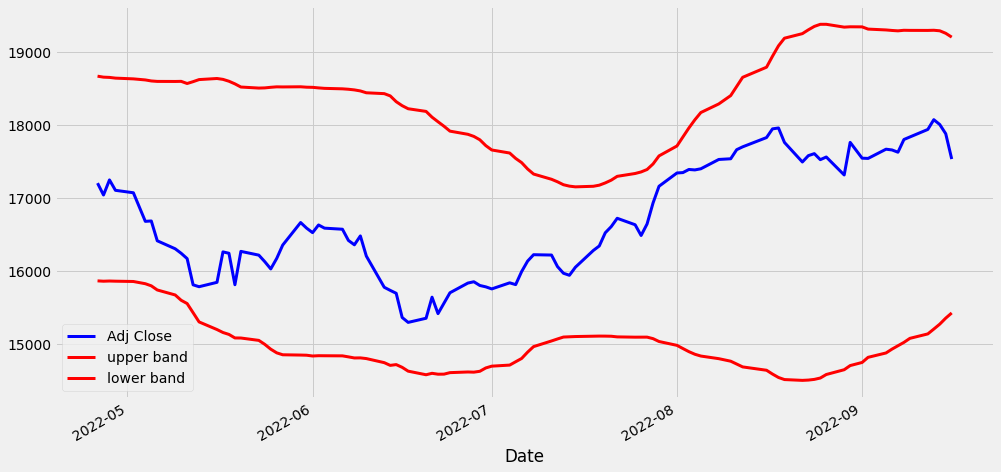

In [ ]:
niftydf[["Adj Close", "upper band", "lower band"]].tail(100).plot(color=('b','r','r'))

###(5) Relative Strength Index

In [ ]:
from ta.momentum import RSIIndicator

iilist = []
jjlist = []
kklist = []
narlist = []
srlist = []
intradelist = []

for ii in range(10, 50, 2):
  for jj in range(10, 40, 2):
    for kk in range(60, 90, 2):
      niftydf = copy.deepcopy(df)
      niftydf["rsi"] = RSIIndicator(close=niftydf["Adj Close"], window=ii).rsi()
      niftydf.dropna(inplace=True)
      niftydf["signal"] = np.where(niftydf["rsi"]<jj, 1, np.where(niftydf["rsi"]>kk, 0, np.nan))

      if (np.isnan(niftydf["signal"][0])):
        niftydf["signal"][0] = 0

      niftydf.signal.fillna(method='ffill', inplace=True)
      niftydf["signal"] = niftydf["signal"].shift(1)
      niftydf.dropna(inplace=True)
      niftydf["ROC"] = np.log(niftydf["Adj Close"] / niftydf["Adj Close"].shift(1))
      niftydf["return"] = niftydf["ROC"]*niftydf["signal"]
      niftydf["portfolio"] = np.exp(niftydf["return"].cumsum())
      niftydf.dropna(inplace=True)
      duration_days = niftydf.index.max()-niftydf.index.min()
      duration_years = duration_days.days/365.25
      duration_in_trade = duration_years * niftydf["signal"].mean()

      if (duration_in_trade!=0):
        net_avg_return = niftydf.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
        returns = niftydf[niftydf["return"]!=0]["return"]
        sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

      if (niftydf["signal"].mean()>0.4):
        iilist.append(ii)
        jjlist.append(jj)
        kklist.append(kk)
        narlist.append(net_avg_return)
        srlist.append(sharpe_ratio)
        intradelist.append(niftydf["signal"].mean())

In [ ]:
# net average return based
print(f"nwindow={iilist[np.argmax(narlist)]};nlow={jjlist[np.argmax(narlist)]};nhigh={kklist[np.argmax(narlist)]};intraderatio={intradelist[np.argmax(narlist)]:.2f}")
print(f"nar: {max(narlist)}")

# sharpe ratio based
print(f"nwindow={iilist[np.argmax(srlist)]};nlow={jjlist[np.argmax(srlist)]};nhigh={kklist[np.argmax(srlist)]};intraderatio={intradelist[np.argmax(srlist)]:.2f}")
print(f"sr: {max(srlist)}")

tilist.append("rsi")
bestnarlist.append(max(narlist))
bestsrlist.append(max(srlist))
bestnarparamlist.append(f"nwindow={iilist[np.argmax(narlist)]};nlow={jjlist[np.argmax(narlist)]};nhigh={kklist[np.argmax(narlist)]};intraderatio={intradelist[np.argmax(narlist)]:.2f}")
bestsrparamlist.append(f"nwindow={iilist[np.argmax(srlist)]};nlow={jjlist[np.argmax(srlist)]};nhigh={kklist[np.argmax(srlist)]};intraderatio={intradelist[np.argmax(srlist)]:.2f}")

nwindow=46;nlow=38;nhigh=68;intraderatio=0.43
nar: 0.23414924734476705
nwindow=46;nlow=38;nhigh=68;intraderatio=0.43
sr: 0.8855576993905129


In [ ]:
comparisondf = pd.DataFrame(np.column_stack([tilist, bestnarlist, bestnarparamlist, bestsrlist, bestsrparamlist]), columns=["Technical Indicator", "Best NAR", "Best NAR Params", "Best SR", "Best SR Paramas"])
comparisondf['Best NAR'] = comparisondf['Best NAR'].astype(float)
comparisondf['Best NAR'] = comparisondf['Best NAR'].map('{:,.2f}'.format)
comparisondf['Best SR'] = comparisondf['Best SR'].astype(float)
comparisondf['Best SR'] = comparisondf['Best SR'].map('{:,.2f}'.format)
comparisondf

,Technical Indicator,Best NAR,Best NAR Params,Best SR,Best SR Paramas
0,sma,0.17,sma1=8;sma2=48;intraderatio=0.64,0.88,sma1=8;sma2=48;intraderatio=0.64
1,ema,0.17,ema1=12;ema2=27;intraderatio=0.64,0.89,ema1=12;ema2=27;intraderatio=0.64
2,macd,0.24,"nfast=4;nslow=50,nsig=3;intraderatio=0.52",1.15,"nfast=4;nslow=62,nsig=3;intraderatio=0.53"
3,bbands,0.23,nema=8;nsigma=2.00;intraderatio=0.47,0.82,nema=8;nsigma=2.00;intraderatio=0.47
4,rsi,0.23,nwindow=46;nlow=38;nhigh=68;intraderatio=0.43,0.89,nwindow=46;nlow=38;nhigh=68;intraderatio=0.43


##B. Machine Learning based Trading Strategy

### (1) Data Preparation

In [ ]:
from ta.trend import SMAIndicator, EMAIndicator
from ta import trend
from ta.momentum import RSIIndicator, ROCIndicator
import copy

In [ ]:
def SMA(df, window):
  sma = SMAIndicator(close=df, window=window, fillna=True).sma_indicator()
  return sma

def EMA(df, window):
  ema = EMAIndicator(close=df, window=window, fillna=True).ema_indicator()
  return ema

def RSI(df, window):
  rsi = RSIIndicator(close=niftydf["Adj Close"], window=window, fillna=True).rsi()
  return rsi

def ROC(df, window):
  roc = ROCIndicator(close=df, window=window, fillna=True).roc()
  return roc

def MACD(df, window_slow, window_fast, window_sign):
  macd = trend.MACD(close=df, window_slow=window_slow, window_fast=window_fast, window_sign=window_sign, fillna=True).macd()
  macd_signal = trend.MACD(close=df, window_slow=window_slow, window_fast=window_fast, window_sign=window_sign, fillna=True).macd_signal()
  return macd, macd_signal

def AROON(df, window):
  aroon = trend.AroonIndicator(close=df, window=window, fillna=True).aroon_indicator()
  return aroon

def TRIX(df, window):
  trix = trend.trix(close=df, window=window, fillna=True)
  return trix

def DPO(df, window):
  dpo = trend.dpo(close=df, window=window, fillna=True)
  return dpo

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

Target Ratio: 0.5292864749733759
Shape: (2817, 67)


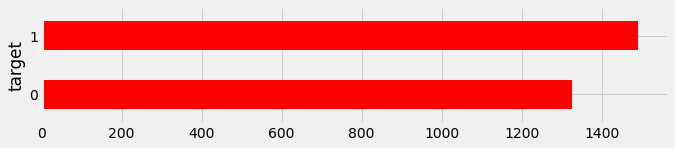

In [ ]:
df = yf.download("^NSEI", start="2010-12-31", end="2022-09-18", progress=False)

df["SMA_5"] = SMA(df["Adj Close"], 5).shift(1)
df["SMA_10"] = SMA(df["Adj Close"], 10).shift(1)
df["SMA_20"] = SMA(df["Adj Close"], 20).shift(1)
df["SMA_30"] = SMA(df["Adj Close"], 30).shift(1)
df["SMA_40"] = SMA(df["Adj Close"], 40).shift(1)
df["SMA_50"] = SMA(df["Adj Close"], 50).shift(1)
df["SMA_60"] = SMA(df["Adj Close"], 60).shift(1)
df["SMA_70"] = SMA(df["Adj Close"], 70).shift(1)
df["SMA_80"] = SMA(df["Adj Close"], 80).shift(1)
df["SMA_90"] = SMA(df["Adj Close"], 90).shift(1)
df["SMA_100"] = SMA(df["Adj Close"], 100).shift(1)
df["EMA_5"] = EMA(df["Adj Close"], 5).shift(1)
df["EMA_10"] = EMA(df["Adj Close"], 10).shift(1)
df["EMA_20"] = EMA(df["Adj Close"], 20).shift(1)
df["EMA_30"] = EMA(df["Adj Close"], 30).shift(1)
df["EMA_40"] = EMA(df["Adj Close"], 40).shift(1)
df["EMA_50"] = EMA(df["Adj Close"], 50).shift(1)
df["EMA_60"] = EMA(df["Adj Close"], 60).shift(1)
df["EMA_70"] = EMA(df["Adj Close"], 70).shift(1)
df["EMA_80"] = EMA(df["Adj Close"], 80).shift(1)
df["EMA_90"] = EMA(df["Adj Close"], 90).shift(1)
df["EMA_100"] = EMA(df["Adj Close"], 100).shift(1)
df["RSI_7"] = RSI(df["Adj Close"], 7).shift(1)
df["RSI_14"] = RSI(df["Adj Close"], 14).shift(1)
df["RSI_21"] = RSI(df["Adj Close"], 21).shift(1)
df["RSI_28"] = RSI(df["Adj Close"], 28).shift(1)
df["RSI_35"] = RSI(df["Adj Close"], 35).shift(1)
df["RSI_42"] = RSI(df["Adj Close"], 42).shift(1)
df["ROC_1"] = ROC(df["Adj Close"], 1).shift(1)
df["ROC_5"] = ROC(df["Adj Close"], 5).shift(1)
df["ROC_10"] = ROC(df["Adj Close"], 10).shift(1)
df["ROC_15"] = ROC(df["Adj Close"], 15).shift(1)
df["ROC_20"] = ROC(df["Adj Close"], 20).shift(1)
df["ROC_25"] = ROC(df["Adj Close"], 25).shift(1)
df["ROC_30"] = ROC(df["Adj Close"], 30).shift(1)
df["ROC_35"] = ROC(df["Adj Close"], 35).shift(1)
df["ROC_40"] = ROC(df["Adj Close"], 40).shift(1)
df["ROC_45"] = ROC(df["Adj Close"], 45).shift(1)
df["ROC_50"] = ROC(df["Adj Close"], 50).shift(1)
df["MACD_12_4_3"], df["MACD_SIGNAL_12_4_3"] = MACD(df["Adj Close"], 12, 4, 3)
df["MACD_26_12_9"], df["MACD_SIGNAL_26_12_9"] = MACD(df["Adj Close"], 26, 12, 9)
df["MACD_52_24_18"], df["MACD_SIGNAL_52_24_18"] = MACD(df["Adj Close"], 52, 24, 18)
df["MACD_12_4_3"] = df["MACD_12_4_3"].shift(1)
df["MACD_26_12_9"] = df["MACD_26_12_9"].shift(1)
df["MACD_52_24_18"] = df["MACD_52_24_18"].shift(1)
df["MACD_SIGNAL_12_4_3"] = df["MACD_SIGNAL_12_4_3"].shift(1)
df["MACD_SIGNAL_26_12_9"] = df["MACD_SIGNAL_26_12_9"].shift(1)
df["MACD_SIGNAL_52_24_18"] = df["MACD_SIGNAL_52_24_18"].shift(1)
df["DPO_10"] = DPO(df["Adj Close"], 10).shift(1)
df["DPO_20"] = DPO(df["Adj Close"], 20).shift(1)
df["DPO_30"] = DPO(df["Adj Close"], 30).shift(1)
df["DPO_40"] = DPO(df["Adj Close"], 40).shift(1)
df["DPO_50"] = DPO(df["Adj Close"], 50).shift(1)
df["TRIX_10"] = TRIX(df["Adj Close"], 10).shift(1)
df["TRIX_20"] = TRIX(df["Adj Close"], 20).shift(1)
df["TRIX_30"] = TRIX(df["Adj Close"], 30).shift(1)
df["TRIX_40"] = TRIX(df["Adj Close"], 40).shift(1)
df["TRIX_50"] = TRIX(df["Adj Close"], 50).shift(1)
df["AROON_10"] = AROON(df["Adj Close"], 10).shift(1)
df["AROON_20"] = AROON(df["Adj Close"], 20).shift(1)
df["AROON_30"] = AROON(df["Adj Close"], 30).shift(1)
df["AROON_40"] = AROON(df["Adj Close"], 40).shift(1)
df["AROON_50"] = AROON(df["Adj Close"], 50).shift(1)
df['%K10'] = STOK(df['Close'], df['Low'], df['High'], 10)
df['%K20'] = STOK(df['Close'], df['Low'], df['High'], 20)
df['%K30'] = STOK(df['Close'], df['Low'], df['High'], 30)
df['%K40'] = STOK(df['Close'], df['Low'], df['High'], 40)
df['%K50'] = STOK(df['Close'], df['Low'], df['High'], 50)
df['%K10'] = STOD(df['Close'], df['Low'], df['High'], 10)
df['%K20'] = STOD(df['Close'], df['Low'], df['High'], 20)
df['%K30'] = STOD(df['Close'], df['Low'], df['High'], 30)
df['%K40'] = STOD(df['Close'], df['Low'], df['High'], 40)
df['%K50'] = STOD(df['Close'], df['Low'], df['High'], 50)

df.drop(["Open", "High", "Low", "Close", "Volume"], axis=1, inplace=True)
df["target"] = np.where(df["Adj Close"] < df["Adj Close"].shift(-1), 1, 0)
df.dropna(inplace=True)
target_ratio = df["target"].mean()
print(f"Target Ratio: {target_ratio}")
print(f"Shape: {df.shape}")

f, ax = plt.subplots(figsize=(10,2))
plot = df.groupby(['target']).size().plot(kind='barh', color='red')
plt.show()

### (2) Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
X = df.drop(['target'], axis=1)
Y = df["target"]

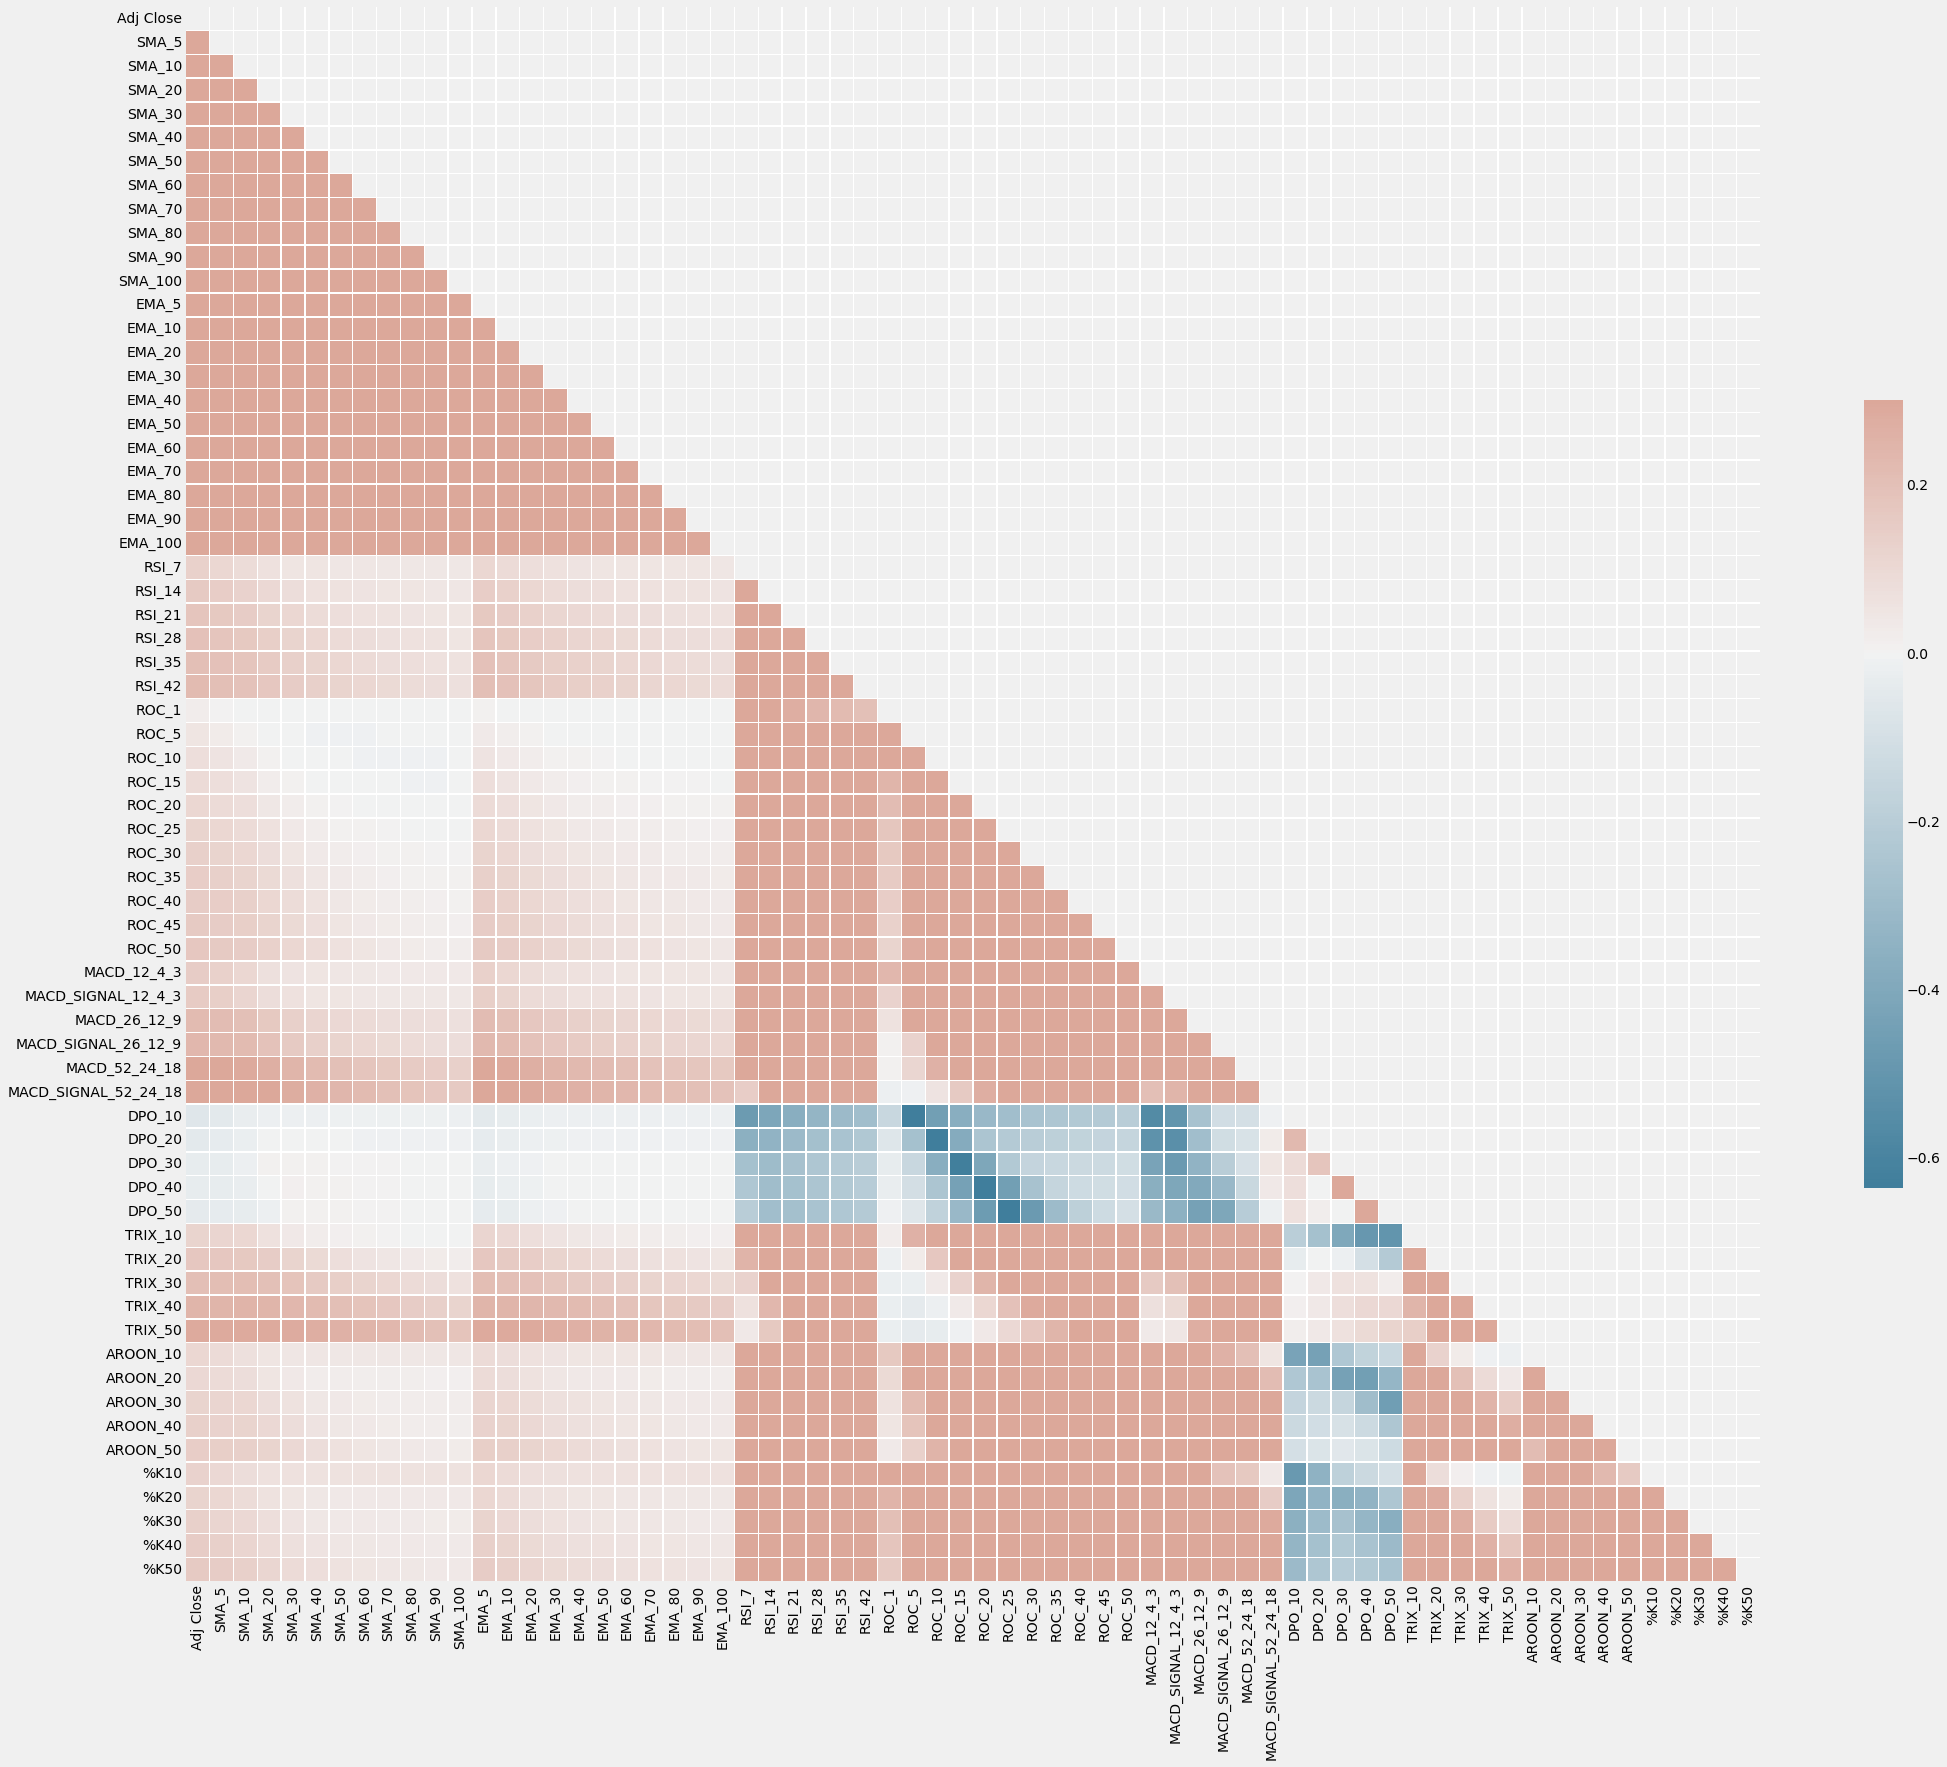

In [ ]:
corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(33, 27))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr

,Adj Close,SMA_5,SMA_10,SMA_20,SMA_30,SMA_40,SMA_50,SMA_60,SMA_70,SMA_80,...,AROON_10,AROON_20,AROON_30,AROON_40,AROON_50,%K10,%K20,%K30,%K40,%K50
Adj Close,1.000000,0.998977,0.998135,0.996426,0.994684,0.992974,0.991333,0.989760,0.988249,0.986776,...,0.106226,0.100953,0.122583,0.131758,0.144575,0.127028,0.123899,0.134359,0.148193,0.162696
SMA_5,0.998977,1.000000,0.999592,0.998107,0.996451,0.994756,0.993117,0.991530,0.990001,0.988509,...,0.092596,0.093156,0.116796,0.127676,0.142078,0.100955,0.103284,0.116667,0.132519,0.148571
SMA_10,0.998135,0.999592,1.000000,0.999154,0.997718,0.996126,0.994531,0.992965,0.991447,0.989955,...,0.071783,0.079328,0.107130,0.119638,0.136020,0.082088,0.084767,0.099851,0.117018,0.134238
SMA_20,0.996426,0.998107,0.999154,1.000000,0.999427,0.998269,0.996898,0.995464,0.994026,0.992584,...,0.053588,0.049991,0.083523,0.100034,0.119904,0.068269,0.059909,0.074107,0.092230,0.110331
SMA_30,0.994684,0.996451,0.997718,0.999427,1.000000,0.999567,0.998621,0.997446,0.996178,0.994850,...,0.047253,0.033080,0.059602,0.078341,0.100801,0.063656,0.047595,0.055249,0.072260,0.090156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
%K10,0.127028,0.100955,0.082088,0.068269,0.063656,0.061822,0.061324,0.061193,0.061063,0.061038,...,0.809063,0.482290,0.312142,0.227158,0.161111,1.000000,0.868060,0.745216,0.665253,0.598494
%K20,0.123899,0.103284,0.084767,0.059909,0.047595,0.041686,0.038795,0.037116,0.035732,0.034697,...,0.778676,0.780925,0.569882,0.440330,0.341719,0.868060,1.000000,0.922620,0.846802,0.781473
%K30,0.134359,0.116667,0.099851,0.074107,0.055249,0.043784,0.037482,0.033863,0.031290,0.029379,...,0.697914,0.801274,0.768827,0.637188,0.516885,0.745216,0.922620,1.000000,0.957216,0.904509
%K40,0.148193,0.132519,0.117018,0.092230,0.072260,0.056772,0.046926,0.041095,0.037194,0.034337,...,0.636047,0.766089,0.802782,0.775177,0.652444,0.665253,0.846802,0.957216,1.000000,0.968782


In [ ]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
to_drop

['SMA_5',
 'SMA_10',
 'SMA_20',
 'SMA_30',
 'SMA_40',
 'SMA_50',
 'SMA_60',
 'SMA_70',
 'SMA_80',
 'SMA_90',
 'SMA_100',
 'EMA_5',
 'EMA_10',
 'EMA_20',
 'EMA_30',
 'EMA_40',
 'EMA_50',
 'EMA_60',
 'EMA_70',
 'EMA_80',
 'EMA_90',
 'EMA_100',
 'RSI_35',
 'RSI_42']

In [ ]:
X.drop(to_drop, axis=1, inplace=True)
df.drop(to_drop, axis=1, inplace=True)
X.shape

(2817, 42)

In [ ]:
# X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = X[:-800], X[-800:], Y[:-800], Y[-800:]

### (3) Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train.drop("Adj Close", axis=1))
rescaledX_train = pd.DataFrame(scaler.transform(X_train.drop("Adj Close", axis=1)), columns=X_train.drop("Adj Close", axis=1).columns, index=X_train.index)
rescaledX_valid = pd.DataFrame(scaler.transform(X_valid.drop("Adj Close", axis=1)), columns=X_valid.drop("Adj Close", axis=1).columns, index=X_valid.index)

### (4) Model Instantiation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=29)))
models.append(('NB', GaussianNB()))
models.append(('NN', MLPClassifier(random_state=42)))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=29, n_jobs=-1)))

### (5) Cross-Validation

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=29, shuffle=True)
    cv_results = cross_val_score(model, rescaledX_train, Y_train, cv=kfold, scoring="balanced_accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.512206 (0.016986)
LDA: 0.517177 (0.010722)
KNN: 0.509010 (0.016938)
CART: 0.506820 (0.013720)
NB: 0.501318 (0.025920)
NN: 0.487747 (0.024613)
AB: 0.502292 (0.009246)
GBM: 0.503029 (0.020599)
RF: 0.524418 (0.015336)


### (6) Hyper-parameter Tuning

In [ ]:
# from sklearn.model_selection import KFold, GridSearchCV

# penalty = ['l1', 'l2', 'none']
# C = np.logspace(-4, 4, 9)
# fit_intercept = [True, False]
# param_grid = dict(penalty=penalty, C=C, fit_intercept=fit_intercept)
# gsmodel = LogisticRegression(solver='saga', random_state=42)
# kfold = KFold(n_splits=5, random_state=42, shuffle=True)
# grid = GridSearchCV(estimator=gsmodel, param_grid=param_grid, scoring="accuracy", cv=kfold)
# grid_result = grid.fit(rescaledX_train, Y_train)

# #Print Results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# ranks = grid_result.cv_results_['rank_test_score']
# # for mean, stdev, param, rank in zip(means, stds, params, ranks):
# #     print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

n_estimators = [10, 20, 30, 40, 50]
max_depth= [5, 6, 7, 8, 9, 10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
gsmodel = RandomForestClassifier(random_state=42, n_jobs=-1)
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
grid = GridSearchCV(estimator=gsmodel, param_grid=param_grid, scoring="accuracy", cv=kfold)
grid_result = grid.fit(rescaledX_train, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
# for mean, stdev, param, rank in zip(means, stds, params, ranks):
#     print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.540910 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 30}


### (7) Finalizing Model

In [ ]:
# model = LogisticRegression(C = grid_result.best_params_['C'], 
#                               fit_intercept = grid_result.best_params_['fit_intercept'], 
#                               penalty = grid_result.best_params_['penalty'],
#                               solver='saga')
# model.fit(rescaledX_train, Y_train)

In [ ]:
model = RandomForestClassifier(criterion = grid_result.best_params_['criterion'], 
                              n_estimators = grid_result.best_params_['n_estimators'], 
                              max_depth = grid_result.best_params_['max_depth'], random_state=17)
model.fit(rescaledX_train, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=30,
                       random_state=17)

### (8) Training Metrics

*** Training Metrics ***
Accuracy Score: 0.9152


Text(0.5, 1.0, 'Training Confusion Matrix')

Text(0.5, 3.6999999999999815, 'predicted')

Text(7.300000000000001, 0.5, 'actual')

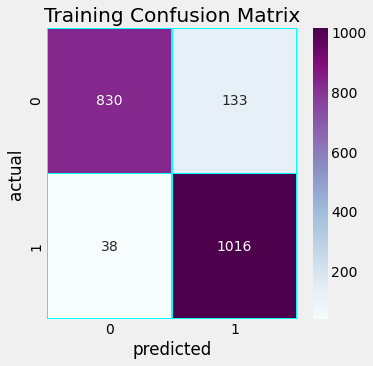

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
# proba = model.predict(rescaledX_train)
proba = (model.predict_proba(rescaledX_train)[:,1] >= 0.50).astype(bool) 

acc_score = accuracy_score(Y_train, proba)
cm = confusion_matrix(Y_train, proba)
print("*** Training Metrics ***")
print(f"Accuracy Score: {acc_score:.4f}")

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('Training Confusion Matrix')
plt.xlabel('predicted', )
plt.ylabel('actual')
plt.show()

In [ ]:
X_valid_saved = copy.deepcopy(X_valid)
X_valid_saved.shape

(800, 42)

### (9) Testing Metrics

*** Validation Metrics ***
Accuracy Score: 0.5112


Text(0.5, 1.0, 'Validation Confusion Matrix')

Text(0.5, 3.6999999999999815, 'predicted')

Text(7.300000000000001, 0.5, 'actual')

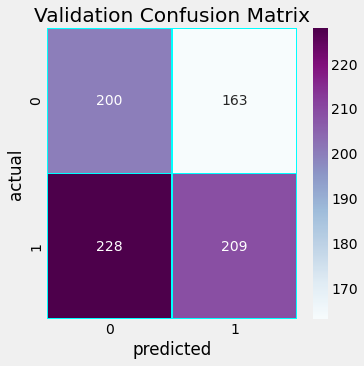

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_valid = copy.deepcopy(X_valid_saved)
# proba = model.predict(rescaledX_valid)
proba = (model.predict_proba(rescaledX_valid)[:,1] >= 0.50).astype(bool) 
X_valid['signal'] = proba

acc_score = accuracy_score(Y_valid, proba)
cm = confusion_matrix(Y_valid, proba)
print("*** Validation Metrics ***")
print(f"Accuracy Score: {acc_score:.4f}")

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('Validation Confusion Matrix')
plt.xlabel('predicted', )
plt.ylabel('actual')
plt.show()

### (10) Machine Learning Model Strategy Net Average Returns & Sharpe Ratio on Testing Dataset

In [ ]:
X_valid["ROC"] = np.log(X_valid["Adj Close"] / X_valid["Adj Close"].shift(1))
X_valid["return"] = X_valid["ROC"]*X_valid["signal"]
X_valid["portfolio"] = np.exp(X_valid["return"].cumsum())
X_valid.dropna(inplace=True)
duration_days = X_valid.index.max()-X_valid.index.min()
duration_years = duration_days.days/365.25
duration_percentage = X_valid["signal"].mean()
duration_in_trade = duration_years * duration_percentage

if (duration_in_trade!=0):
  net_avg_return = X_valid.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
  returns = X_valid[X_valid["return"]!=0]["return"]
  sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

print("*** Model Validation (Validation Set) ***")
print(f"Net Average Return: {net_avg_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Duration Percentage: {duration_percentage:.2f}")

X_valid = copy.deepcopy(X_valid_saved)

*** Model Validation (Validation Set) ***
Net Average Return: 0.34
Sharpe Ratio: 1.07
Duration Percentage: 0.46


### (11) Buy & Hold Strategy Net Average Returns & Sharpe Ratio on Testing Dataset

In [ ]:
X_valid["ROC"] = np.log(X_valid["Adj Close"] / X_valid["Adj Close"].shift(1))
X_valid["return"] = X_valid["ROC"]
X_valid["portfolio"] = np.exp(X_valid["return"].cumsum())
X_valid.dropna(inplace=True)
duration_days = X_valid.index.max()-X_valid.index.min()
duration_years = duration_days.days/365.25
duration_percentage = 1
duration_in_trade = duration_years * duration_percentage

if (duration_in_trade!=0):
  net_avg_return = X_valid.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
  returns = X_valid[X_valid["return"]!=0]["return"]
  sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

print("*** Buy & Hold (Validation Set) ***")
print(f"Net Average Return: {net_avg_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Duration Percentage: {duration_percentage:.2f}")

*** Buy & Hold (Validation Set) ***
Net Average Return: 0.13
Sharpe Ratio: 0.38
Duration Percentage: 1.00


In [ ]:
# df_saved = copy.deepcopy(df)

### (12) Machine Learning Model Metrics on Entire Dataset

In [ ]:
# predictionsdf = scaler.transform(df[X_train.columns].drop("Adj Close", axis=1))
# predictionsdf = pd.DataFrame(predictionsdf, columns=df[X_train.columns].drop("Adj Close", axis=1).columns)
# predictions = model.predict(predictionsdf)
# proba = (model.predict_proba(predictionsdf)[:,1] >= 0.4).astype(bool) 
# df["signal"] = proba

# acc_score = accuracy_score(df["target"], df["signal"])
# cm = confusion_matrix(df["target"], df["signal"])
# print("*** Entire Dataset Metrics ***")
# print(f"Accuracy Score: {acc_score:.4f}")

# f, ax = plt.subplots(figsize=(5,5))
# sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
# plt.title('Entire Dataset Confusion Matrix')
# plt.xlabel('predicted', )
# plt.ylabel('actual')
# plt.show()

### (13) Machine Learning Model Strategy Net Average Returns & Sharpe Ratio on Entire Dataset

In [ ]:
# df["ROC"] = np.log(df["Adj Close"] / df["Adj Close"].shift(1))
# df["return"] = df["ROC"]*df["signal"]
# df["portfolio"] = np.exp(df["return"].cumsum())
# df.dropna(inplace=True)
# duration_days = df.index.max()-df.index.min()
# duration_years = duration_days.days/365.25
# duration_percentage = df["signal"].mean()
# duration_in_trade = duration_years * duration_percentage

# if (duration_in_trade!=0):
#   net_avg_return = df.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
#   returns = df[df["return"]!=0]["return"]
#   sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

# print("*** Entire Dataset ***")
# print(f"Net Average Return: {net_avg_return:.2f}")
# print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
# print(f"Duration Percentage: {duration_percentage:.2f}")

# df = copy.deepcopy(df_saved)

## C. Speed-up Strategies for Model Training

### I. Singular Value Decomposition

Text(0.5, 0, 'Eigenvalues')

Text(0, 0.5, 'Percentage Explained')

Variance preserved by first 7 components == 90.42%


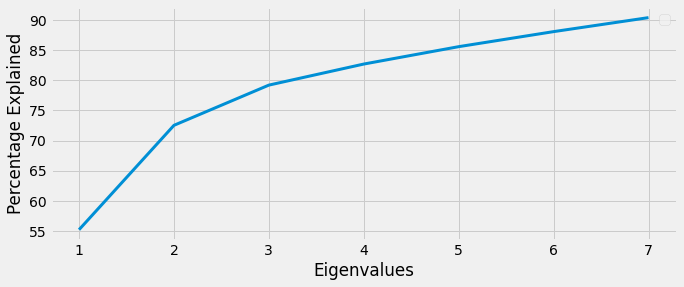

In [ ]:
from sklearn.decomposition import TruncatedSVD

ncomps = 7
svd = TruncatedSVD(n_components=ncomps, random_state=42)
svd_fit = svd.fit(rescaledX_train)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
svdX_train = svd.fit_transform(rescaledX_train)
svdX_valid = svd.transform(rescaledX_valid)
ax = plt_data.plot(kind='line', figsize=(10, 4))
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Percentage Explained")
ax.legend("")
print(f'Variance preserved by first {ncomps} components == {svd_fit.explained_variance_ratio_.cumsum()[-1]:.2%}')

In [ ]:
svdX_train = pd.DataFrame(svdX_train, columns=['c{}'.format(c) for c in range(ncomps)], index=rescaledX_train.index)
svdX_valid = pd.DataFrame(svdX_valid, columns=['c{}'.format(c) for c in range(ncomps)], index=rescaledX_valid.index)
print(svdX_train.shape)
svdX_train.head()

(2017, 7)


,c0,c1,c2,c3,c4,c5,c6
Date,,,,,,,
2011-03-16,6.944809,3.426809,4.595961,-0.147997,2.753940,-1.588952,0.605676
2011-03-17,3.684543,3.904788,2.655909,1.652704,0.775941,-0.054524,-1.519488
2011-03-18,5.420472,2.806451,4.151026,1.042419,1.036950,-0.641342,0.742983
2011-03-21,6.583283,2.379264,4.782555,0.558805,1.054816,-0.618910,1.266580
2011-03-22,6.541834,2.338985,4.671728,0.404019,0.712659,0.576554,1.155880


Time Without Dimensionality Reduction

In [ ]:
import time

# spot check the algorithms
# models =  LogisticRegression()
models = RandomForestClassifier(random_state=42, n_jobs=-1)

start_time = time.time()
cv_results_XTrain= cross_val_score(models, rescaledX_train, Y_train, cv=10, scoring="accuracy")
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time Without Dimensionality Reduction--- 10.42034125328064 seconds ---


Time With Dimensionality Reduction

In [ ]:
start_time = time.time()
cv_results_SVD = cross_val_score(models, svdX_train, Y_train, cv=10, scoring="accuracy")
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time with Dimensionality Reduction--- 6.350998401641846 seconds ---


In [ ]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Result without dimensionality Reduction: 0.467098 (0.040666)
Result with dimensionality Reduction: 0.488407 (0.043540)


#####(1) Model Creation

In [ ]:
# from sklearn.model_selection import KFold, GridSearchCV

# penalty = ['l1', 'l2', 'none']
# C = np.logspace(-4, 4, 9)
# fit_intercept = [True, False]
# param_grid = dict(penalty=penalty, C=C, fit_intercept=fit_intercept)
# gsmodel = LogisticRegression(solver='saga', random_state=42)
# kfold = KFold(n_splits=5, random_state=42, shuffle=True)
# grid = GridSearchCV(estimator=gsmodel, param_grid=param_grid, scoring="accuracy", cv=kfold)
# grid_result = grid.fit(svdX_train, Y_train)

# #Print Results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# ranks = grid_result.cv_results_['rank_test_score']
# # for mean, stdev, param, rank in zip(means, stds, params, ranks):
# #     print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
# modelSVD = LogisticRegression(C = grid_result.best_params_['C'], 
#                               fit_intercept = grid_result.best_params_['fit_intercept'], 
#                               penalty = grid_result.best_params_['penalty'],
#                               solver='saga')
# modelSVD.fit(svdX_train, Y_train)

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

n_estimators = [10, 20, 30, 40, 50]
max_depth = [5, 6, 7, 8, 9, 10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
gsmodel = RandomForestClassifier(random_state=42, n_jobs=-1)
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
grid = GridSearchCV(estimator=gsmodel, param_grid=param_grid, scoring="accuracy", cv=kfold)
grid_result = grid.fit(svdX_train, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
# for mean, stdev, param, rank in zip(means, stds, params, ranks):
#     print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.537427 using {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 30}


In [ ]:
modelSVD = RandomForestClassifier(criterion = grid_result.best_params_['criterion'], 
                              n_estimators = grid_result.best_params_['n_estimators'], 
                              max_depth = grid_result.best_params_['max_depth'], random_state=42)
modelSVD.fit(svdX_train, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=30,
                       random_state=42)

#####(2) Training Metrics

*** Training Metrics ***
Accuracy Score: 0.7843


Text(0.5, 1.0, 'Training Confusion Matrix')

Text(0.5, 3.6999999999999815, 'predicted')

Text(7.300000000000001, 0.5, 'actual')

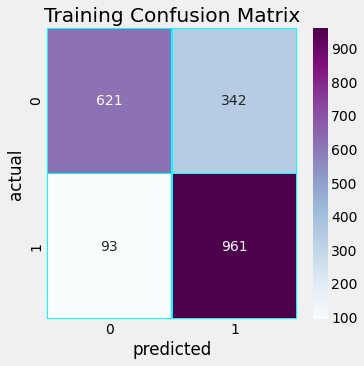

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
# proba = modelSVD.predict(svdX_train)
proba = (modelSVD.predict_proba(svdX_train)[:,1] >= 0.5).astype(bool) 

acc_score = accuracy_score(Y_train, proba)
cm = confusion_matrix(Y_train, proba)
print("*** Training Metrics ***")
print(f"Accuracy Score: {acc_score:.4f}")

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('Training Confusion Matrix')
plt.xlabel('predicted', )
plt.ylabel('actual')
plt.show()

In [ ]:
# X_valid_saved = copy.deepcopy(X_valid)
X_valid_saved.shape

(800, 42)

#####(3) Validation Metrics

*** Validation Metrics ***
Accuracy Score: 0.5175


Text(0.5, 1.0, 'Validation Confusion Matrix')

Text(0.5, 3.6999999999999815, 'predicted')

Text(7.300000000000001, 0.5, 'actual')

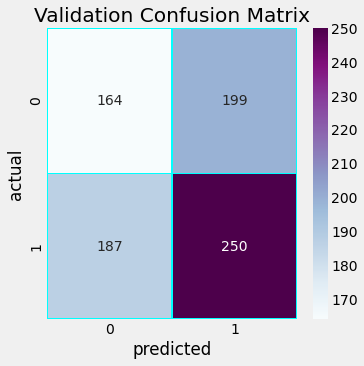

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_valid = copy.deepcopy(X_valid_saved)
# proba = modelSVD.predict(rescaledX_valid)
proba = (modelSVD.predict_proba(svdX_valid)[:,1] >= 0.5).astype(bool) 
X_valid['signal'] = proba

acc_score = accuracy_score(Y_valid, proba)
cm = confusion_matrix(Y_valid, proba)
print("*** Validation Metrics ***")
print(f"Accuracy Score: {acc_score:.4f}")

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('Validation Confusion Matrix')
plt.xlabel('predicted', )
plt.ylabel('actual')
plt.show()

#####(4) Net Average Returns & Sharpe Ratio on Testing Dataset (Dimensionality Reduction)

In [ ]:
X_valid["ROC"] = np.log(X_valid["Adj Close"] / X_valid["Adj Close"].shift(1))
X_valid["return"] = X_valid["ROC"]*X_valid["signal"]
X_valid["portfolio"] = np.exp(X_valid["return"].cumsum())
X_valid.dropna(inplace=True)
duration_days = X_valid.index.max()-X_valid.index.min()
duration_years = duration_days.days/365.25
duration_percentage = X_valid["signal"].mean()
duration_in_trade = duration_years * duration_percentage

if (duration_in_trade!=0):
  net_avg_return = X_valid.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
  returns = X_valid[X_valid["return"]!=0]["return"]
  sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

print("*** Model Validation (Validation Set) ***")
print(f"Net Average Return: {net_avg_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Duration Percentage: {duration_percentage:.2f}")

X_valid = copy.deepcopy(X_valid_saved)

*** Model Validation (Validation Set) ***
Net Average Return: 0.27
Sharpe Ratio: 1.07
Duration Percentage: 0.56


#####(5) Buy & Hold Strategy Net Average Returns & Sharpe Ratio on Testing Dataset

In [ ]:
X_valid.loc[:, "ROC"] = np.log(X_valid.loc[:, "Adj Close"] / X_valid.loc[:, "Adj Close"].shift(1))
X_valid["return"] = X_valid["ROC"]
X_valid["portfolio"] = np.exp(X_valid["return"].cumsum())
X_valid.dropna(inplace=True)
duration_days = X_valid.index.max()-X_valid.index.min()
duration_years = duration_days.days/365.25
duration_percentage = 1
duration_in_trade = duration_years * duration_percentage

if (duration_in_trade!=0):
  net_avg_return = X_valid.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
  returns = X_valid[X_valid["return"]!=0]["return"]
  sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

print("*** Buy & Hold (Validation Set) ***")
print(f"Net Average Return: {net_avg_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Duration Percentage: {duration_percentage:.2f}")

X_valid = copy.deepcopy(X_valid_saved)

*** Buy & Hold (Validation Set) ***
Net Average Return: 0.13
Sharpe Ratio: 0.38
Duration Percentage: 1.00


### II. Random Forest based Feature Selection

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [ ]:
rf.fit(rescaledX_train, Y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

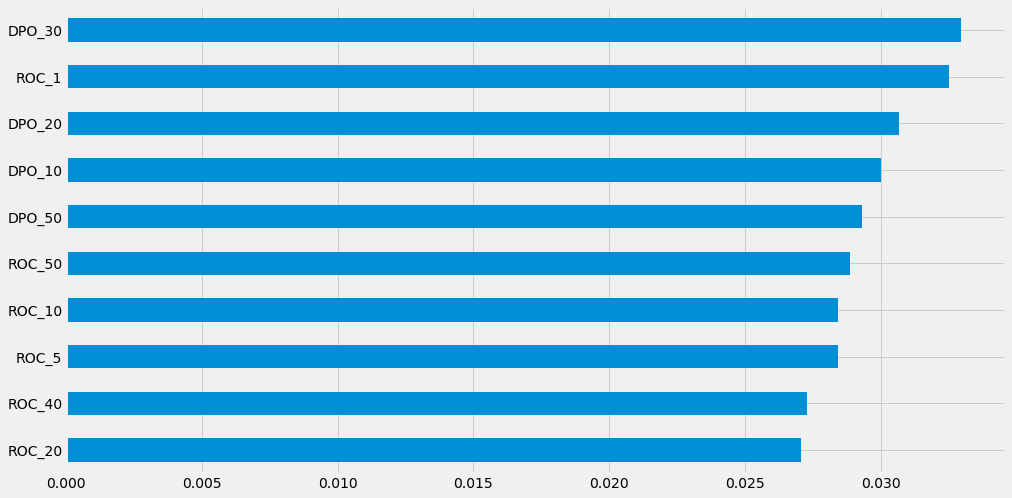

In [ ]:
importancedf = pd.Series(rf.feature_importances_, index=X_train.drop(["Adj Close"], axis=1).columns)
importancedf.nlargest(10).sort_values().plot(kind='barh')

In [ ]:
rfX_train = rescaledX_train[importancedf.nlargest(10).index.tolist()]
rfX_valid = rescaledX_valid[importancedf.nlargest(10).index.tolist()]

In [ ]:
print(rfX_train.shape)
rfX_train.head()

(2017, 10)


,DPO_30,ROC_1,DPO_20,DPO_10,DPO_50,ROC_50,ROC_10,ROC_5,ROC_40,ROC_20
Date,,,,,,,,,,
2011-03-16,0.244296,-1.589882,-1.592462,-0.467733,-1.128881,-2.199733,0.567163,-0.674263,-0.940795,-0.228749
2011-03-17,0.721545,1.135491,-1.308463,0.305030,-1.042462,-2.088747,-0.203808,-0.256585,-0.748004,-0.073178
2011-03-18,0.300281,-1.266632,0.613583,0.556923,-1.497906,-2.236437,-0.661531,-0.485746,-1.158201,-0.350836
2011-03-21,0.074412,-1.443218,0.840619,0.292670,-1.792183,-2.274773,-1.102032,-0.687223,-1.288027,-0.928615
2011-03-22,-1.391636,-0.217747,0.913750,-0.221626,-1.884510,-2.222561,-0.720901,-1.449449,-1.376305,-0.604386


Time Without Dimensionality Reduction

In [ ]:
import time

# spot check the algorithms
# models =  LogisticRegression()
models = RandomForestClassifier(random_state=42, n_jobs=-1)

start_time = time.time()
cv_results_XTrain= cross_val_score(models, rescaledX_train, Y_train, cv=10, scoring="accuracy")
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time Without Dimensionality Reduction--- 10.523088932037354 seconds ---


Time With Dimensionality Reduction

In [ ]:
start_time = time.time()
cv_results_RF = cross_val_score(models, rfX_train, Y_train, cv=10, scoring="accuracy")
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time with Dimensionality Reduction--- 7.3682029247283936 seconds ---


In [ ]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_RF.mean(), cv_results_RF.std()))

Result without dimensionality Reduction: 0.467098 (0.040666)
Result with dimensionality Reduction: 0.496288 (0.040980)


#####(1) Model Creation

In [ ]:
# from sklearn.model_selection import KFold, GridSearchCV

# penalty = ['l1', 'l2', 'none']
# C = np.logspace(-4, 4, 9)
# fit_intercept = [True, False]
# param_grid = dict(penalty=penalty, C=C, fit_intercept=fit_intercept)
# gsmodel = LogisticRegression(solver='saga', random_state=42)
# kfold = KFold(n_splits=5)
# grid = GridSearchCV(estimator=gsmodel, param_grid=param_grid, scoring="accuracy", cv=kfold)
# grid_result = grid.fit(rfX_train, Y_train)

# #Print Results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# ranks = grid_result.cv_results_['rank_test_score']
# # for mean, stdev, param, rank in zip(means, stds, params, ranks):
# #     print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
# modelRF = LogisticRegression(C = grid_result.best_params_['C'], 
#                              fit_intercept = grid_result.best_params_['fit_intercept'], 
#                              penalty = grid_result.best_params_['penalty'],
#                              solver='saga')
# modelRF.fit(rfX_train, Y_train)

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

n_estimators = [10, 20, 30, 40, 50]
max_depth = [5, 6, 7, 8, 9, 10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
gsmodel = RandomForestClassifier(random_state=42, n_jobs=-1)
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
grid = GridSearchCV(estimator=gsmodel, param_grid=param_grid, scoring="accuracy", cv=kfold)
grid_result = grid.fit(rfX_train, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
# for mean, stdev, param, rank in zip(means, stds, params, ranks):
#     print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.542902 using {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 10}


In [ ]:
modelRF = RandomForestClassifier(criterion = grid_result.best_params_['criterion'], 
                              n_estimators = grid_result.best_params_['n_estimators'], 
                              max_depth = grid_result.best_params_['max_depth'], random_state=42)
modelRF.fit(rfX_train, Y_train)

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)

#####(2) Training Metrics

*** Training Metrics ***
Accuracy Score: 0.6644


Text(0.5, 1.0, 'Training Confusion Matrix')

Text(0.5, 3.6999999999999815, 'predicted')

Text(7.300000000000001, 0.5, 'actual')

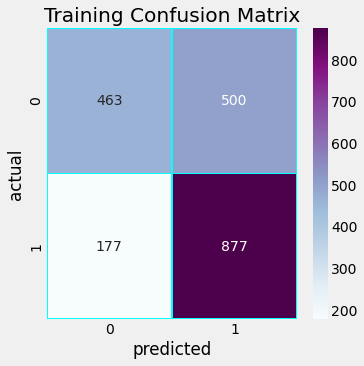

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
# proba = modelRF.predict(rfX_train)
proba = (modelRF.predict_proba(rfX_train)[:,1] >= 0.5).astype(bool) 

acc_score = accuracy_score(Y_train, proba)
cm = confusion_matrix(Y_train, proba)
print("*** Training Metrics ***")
print(f"Accuracy Score: {acc_score:.4f}")

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('Training Confusion Matrix')
plt.xlabel('predicted', )
plt.ylabel('actual')
plt.show()

In [ ]:
# X_valid_saved = copy.deepcopy(X_valid)
X_valid_saved.shape

(800, 42)

#####(3) Validation Metrics

*** Validation Metrics ***
Accuracy Score: 0.5012


Text(0.5, 1.0, 'Validation Confusion Matrix')

Text(0.5, 3.6999999999999815, 'predicted')

Text(7.300000000000001, 0.5, 'actual')

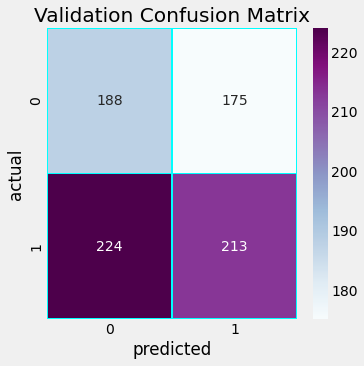

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_valid = copy.deepcopy(X_valid_saved)
# proba = modelRF.predict(rfX_valid)
proba = (modelRF.predict_proba(rfX_valid)[:,1] >= 0.5).astype(bool) 
X_valid['signal'] = proba

acc_score = accuracy_score(Y_valid, proba)
cm = confusion_matrix(Y_valid, proba)
print("*** Validation Metrics ***")
print(f"Accuracy Score: {acc_score:.4f}")

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('Validation Confusion Matrix')
plt.xlabel('predicted', )
plt.ylabel('actual')
plt.show()

#####(4) Net Average Returns & Sharpe Ratio on Testing Dataset (Dimensionality Reduction)

In [ ]:
X_valid["ROC"] = np.log(X_valid["Adj Close"] / X_valid["Adj Close"].shift(1))
X_valid["return"] = X_valid["ROC"]*X_valid["signal"]
X_valid["portfolio"] = np.exp(X_valid["return"].cumsum())
X_valid.dropna(inplace=True)
duration_days = X_valid.index.max()-X_valid.index.min()
duration_years = duration_days.days/365.25
duration_percentage = X_valid["signal"].mean()
duration_in_trade = duration_years * duration_percentage

if (duration_in_trade!=0):
  net_avg_return = X_valid.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
  returns = X_valid[X_valid["return"]!=0]["return"]
  sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

print("*** Model Validation (Validation Set) ***")
print(f"Net Average Return: {net_avg_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Duration Percentage: {duration_percentage:.2f}")

X_valid = copy.deepcopy(X_valid_saved)

*** Model Validation (Validation Set) ***
Net Average Return: 0.08
Sharpe Ratio: 0.15
Duration Percentage: 0.48


#####(5) Buy & Hold Strategy Net Average Returns & Sharpe Ratio on Testing Dataset

In [ ]:
X_valid.loc[:, "ROC"] = np.log(X_valid.loc[:, "Adj Close"] / X_valid.loc[:, "Adj Close"].shift(1))
X_valid["return"] = X_valid["ROC"]
X_valid["portfolio"] = np.exp(X_valid["return"].cumsum())
X_valid.dropna(inplace=True)
duration_days = X_valid.index.max()-X_valid.index.min()
duration_years = duration_days.days/365.25
duration_percentage = 1
duration_in_trade = duration_years * duration_percentage

if (duration_in_trade!=0):
  net_avg_return = X_valid.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
  returns = X_valid[X_valid["return"]!=0]["return"]
  sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

print("*** Buy & Hold (Validation Set) ***")
print(f"Net Average Return: {net_avg_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Duration Percentage: {duration_percentage:.2f}")

X_valid = copy.deepcopy(X_valid_saved)

*** Buy & Hold (Validation Set) ***
Net Average Return: 0.13
Sharpe Ratio: 0.38
Duration Percentage: 1.00


### III. Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=model, n_features_to_select=10)

In [ ]:
rfe.fit(rescaledX_train, Y_train)

RFE(estimator=RandomForestClassifier(criterion='entropy', max_depth=10,
                                     n_estimators=30, random_state=17),
    n_features_to_select=10)

In [ ]:
rfeX_train = rfe.transform(rescaledX_train)
rfeX_valid = rfe.transform(rescaledX_valid)

In [ ]:
rfeX_train = pd.DataFrame(rfeX_train, columns=rescaledX_train.columns[rfe.support_], index=rescaledX_train.index)
rfeX_valid = pd.DataFrame(rfeX_valid, columns=rescaledX_train.columns[rfe.support_], index=rescaledX_valid.index)
print(rfeX_train.shape)
rfeX_train.head()

(2017, 10)


,ROC_5,ROC_40,ROC_50,MACD_52_24_18,DPO_10,DPO_20,DPO_30,DPO_50,%K10,%K50
Date,,,,,,,,,,
2011-03-16,-0.674263,-0.940795,-2.199733,-1.519069,-0.467733,-1.592462,0.244296,-1.128881,-0.075358,-1.070604
2011-03-17,-0.256585,-0.748004,-2.088747,-1.466818,0.305030,-1.308463,0.721545,-1.042462,-0.560281,-1.154325
2011-03-18,-0.485746,-1.158201,-2.236437,-1.444587,0.556923,0.613583,0.300281,-1.497906,-0.882142,-1.225136
2011-03-21,-0.687223,-1.288027,-2.274773,-1.452566,0.292670,0.840619,0.074412,-1.792183,-1.452822,-1.359727
2011-03-22,-1.449449,-1.376305,-2.222561,-1.460249,-0.221626,0.913750,-1.391636,-1.884510,-1.459576,-1.308944


Time Without Dimensionality Reduction

In [ ]:
import time

# spot check the algorithms
# models =  LogisticRegression()
models = RandomForestClassifier(random_state=42, n_jobs=-1)

start_time = time.time()
cv_results_XTrain= cross_val_score(models, rescaledX_train, Y_train, cv=10, scoring="accuracy")
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time Without Dimensionality Reduction--- 10.20437502861023 seconds ---


Time With Dimensionality Reduction

In [ ]:
start_time = time.time()
cv_results_RFE = cross_val_score(models, rfeX_train, Y_train, cv=10, scoring="accuracy")
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time with Dimensionality Reduction--- 7.265915632247925 seconds ---


In [ ]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_RFE.mean(), cv_results_RFE.std()))

Result without dimensionality Reduction: 0.467098 (0.040666)
Result with dimensionality Reduction: 0.487382 (0.022367)


#####(1) Model Creation

In [ ]:
# from sklearn.model_selection import KFold, GridSearchCV

# penalty = ['l1', 'l2', 'none']
# C = np.logspace(-4, 4, 9)
# fit_intercept = [True, False]
# param_grid = dict(penalty=penalty, C=C, fit_intercept=fit_intercept)
# gsmodel = LogisticRegression(solver='saga', random_state=42)
# kfold = KFold(n_splits=5)
# grid = GridSearchCV(estimator=gsmodel, param_grid=param_grid, scoring="accuracy", cv=kfold)
# grid_result = grid.fit(rfeX_train, Y_train)

# #Print Results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# ranks = grid_result.cv_results_['rank_test_score']
# # for mean, stdev, param, rank in zip(means, stds, params, ranks):
# #     print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
# modelRFE = LogisticRegression(C = grid_result.best_params_['C'], 
#                               fit_intercept = grid_result.best_params_['fit_intercept'], 
#                               penalty = grid_result.best_params_['penalty'],
#                               solver = 'saga')
# modelRFE.fit(rfeX_train, Y_train)

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

n_estimators = [10, 20, 30, 40, 50]
max_depth = [5, 6, 7, 8, 9, 10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
gsmodel = RandomForestClassifier(random_state=42, n_jobs=-1)
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
grid = GridSearchCV(estimator=gsmodel, param_grid=param_grid, scoring="accuracy", cv=kfold)
grid_result = grid.fit(rfeX_train, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
# for mean, stdev, param, rank in zip(means, stds, params, ranks):
#     print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.534464 using {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 50}


In [ ]:
modelRFE = RandomForestClassifier(criterion = grid_result.best_params_['criterion'], 
                              n_estimators = grid_result.best_params_['n_estimators'], 
                              max_depth = grid_result.best_params_['max_depth'], random_state=42)
modelRFE.fit(rfeX_train, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=50,
                       random_state=42)

#####(2) Training Metrics

*** Training Metrics ***
Accuracy Score: 0.6787


Text(0.5, 1.0, 'Training Confusion Matrix')

Text(0.5, 3.6999999999999815, 'predicted')

Text(7.300000000000001, 0.5, 'actual')

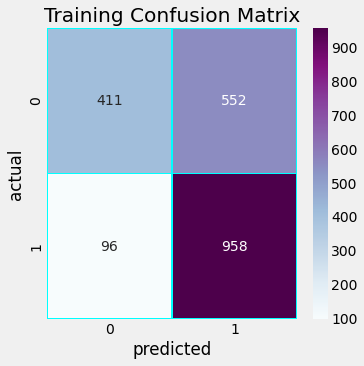

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
# proba = modelRFE.predict(rfeX_train)
proba = (modelRFE.predict_proba(rfeX_train)[:,1] >= 0.5).astype(bool) 

acc_score = accuracy_score(Y_train, proba)
cm = confusion_matrix(Y_train, proba)
print("*** Training Metrics ***")
print(f"Accuracy Score: {acc_score:.4f}")

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('Training Confusion Matrix')
plt.xlabel('predicted', )
plt.ylabel('actual')
plt.show()

In [ ]:
# X_valid_saved = copy.deepcopy(X_valid)
X_valid_saved.shape

(800, 42)

#####(3) Validation Metrics

*** Validation Metrics ***
Accuracy Score: 0.4725


Text(0.5, 1.0, 'Validation Confusion Matrix')

Text(0.5, 3.6999999999999815, 'predicted')

Text(7.300000000000001, 0.5, 'actual')

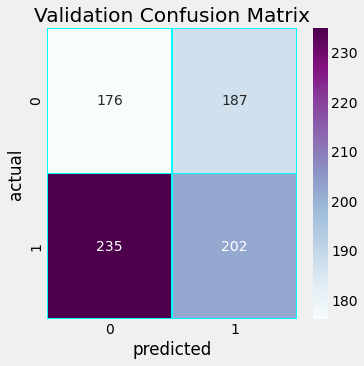

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_valid = copy.deepcopy(X_valid_saved)
# proba = modelRFE.predict(rfeX_valid)
proba = (modelRFE.predict_proba(rfeX_valid)[:,1] >= 0.5).astype(bool) 
X_valid['signal'] = proba

acc_score = accuracy_score(Y_valid, proba)
cm = confusion_matrix(Y_valid, proba)
print("*** Validation Metrics ***")
print(f"Accuracy Score: {acc_score:.4f}")

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('Validation Confusion Matrix')
plt.xlabel('predicted', )
plt.ylabel('actual')
plt.show()

#####(4) Net Average Returns & Sharpe Ratio on Testing Dataset (Dimensionality Reduction)

In [ ]:
X_valid["ROC"] = np.log(X_valid["Adj Close"] / X_valid["Adj Close"].shift(1))
X_valid["return"] = X_valid["ROC"]*X_valid["signal"]
X_valid["portfolio"] = np.exp(X_valid["return"].cumsum())
X_valid.dropna(inplace=True)
duration_days = X_valid.index.max()-X_valid.index.min()
duration_years = duration_days.days/365.25
duration_percentage = X_valid["signal"].mean()
duration_in_trade = duration_years * duration_percentage

if (duration_in_trade!=0):
  net_avg_return = X_valid.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
  returns = X_valid[X_valid["return"]!=0]["return"]
  sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

print("*** Model Validation (Validation Set) ***")
print(f"Net Average Return: {net_avg_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Duration Percentage: {duration_percentage:.2f}")

X_valid = copy.deepcopy(X_valid_saved)

*** Model Validation (Validation Set) ***
Net Average Return: -0.02
Sharpe Ratio: -0.28
Duration Percentage: 0.49


#####(5) Buy & Hold Strategy Net Average Returns & Sharpe Ratio on Testing Dataset

In [ ]:
X_valid.loc[:, "ROC"] = np.log(X_valid.loc[:, "Adj Close"] / X_valid.loc[:, "Adj Close"].shift(1))
X_valid["return"] = X_valid["ROC"]
X_valid["portfolio"] = np.exp(X_valid["return"].cumsum())
X_valid.dropna(inplace=True)
duration_days = X_valid.index.max()-X_valid.index.min()
duration_years = duration_days.days/365.25
duration_percentage = 1
duration_in_trade = duration_years * duration_percentage

if (duration_in_trade!=0):
  net_avg_return = X_valid.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
  returns = X_valid[X_valid["return"]!=0]["return"]
  sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

print("*** Buy & Hold (Validation Set) ***")
print(f"Net Average Return: {net_avg_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Duration Percentage: {duration_percentage:.2f}")

X_valid = copy.deepcopy(X_valid_saved)

*** Buy & Hold (Validation Set) ***
Net Average Return: 0.13
Sharpe Ratio: 0.38
Duration Percentage: 1.00


### IV. Mutual Info based Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

mi_selection = SelectKBest(mutual_info_classif, k=10)
mi_selection.fit(rescaledX_train, Y_train)

SelectKBest(score_func=<function mutual_info_classif at 0x7f93e093b170>)

In [ ]:
miX_train = mi_selection.transform(rescaledX_train)
miX_valid = mi_selection.transform(rescaledX_valid)

In [ ]:
rescaledX_train.columns[mi_selection.get_support()]

Index(['RSI_7', 'ROC_10', 'ROC_25', 'ROC_40', 'MACD_26_12_9', 'MACD_52_24_18',
       'TRIX_40', 'TRIX_50', 'AROON_20', 'AROON_30'],
      dtype='object')

In [ ]:
miX_train = pd.DataFrame(miX_train, columns=rescaledX_train.columns[mi_selection.get_support()], index=rescaledX_train.index)
miX_valid = pd.DataFrame(miX_valid, columns=rescaledX_train.columns[mi_selection.get_support()], index=rescaledX_valid.index)
print(miX_train.shape)
miX_train.head()

(2017, 10)


,RSI_7,ROC_10,ROC_25,ROC_40,MACD_26_12_9,MACD_52_24_18,TRIX_40,TRIX_50,AROON_20,AROON_30
Date,,,,,,,,,,
2011-03-16,-3.014275,0.567163,-0.018125,-0.940795,-0.494182,-1.519069,-2.390854,-2.124123,-0.623173,0.012414
2011-03-17,-0.413913,-0.203808,0.566182,-0.748004,-0.442411,-1.466818,-2.384260,-2.136138,-0.623173,0.012414
2011-03-18,-1.359637,-0.661531,0.552830,-1.158201,-0.467451,-1.444587,-2.376327,-2.146814,-0.623173,0.012414
2011-03-21,-1.896193,-1.102032,0.372811,-1.288027,-0.561217,-1.452566,-2.368911,-2.157203,0.195734,0.012414
2011-03-22,-1.945788,-0.720901,-0.010284,-1.376305,-0.640873,-1.460249,-2.362006,-2.167327,0.195734,0.012414


Time Without Dimensionality Reduction

In [ ]:
import time

# spot check the algorithms
# models =  LogisticRegression()
models = RandomForestClassifier(random_state=42, n_jobs=-1)

start_time = time.time()
cv_results_XTrain= cross_val_score(models, rescaledX_train, Y_train, cv=10, scoring="accuracy")
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time Without Dimensionality Reduction--- 10.288262367248535 seconds ---


Time With Dimensionality Reduction

In [ ]:
start_time = time.time()
cv_results_MI = cross_val_score(models, miX_train, Y_train, cv=10, scoring="accuracy")
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time with Dimensionality Reduction--- 7.032628059387207 seconds ---


In [ ]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_MI.mean(), cv_results_MI.std()))

Result without dimensionality Reduction: 0.467098 (0.040666)
Result with dimensionality Reduction: 0.442318 (0.050245)


#####(1) Model Creation

In [ ]:
# from sklearn.model_selection import KFold, GridSearchCV

# penalty = ['l1', 'l2', 'none']
# C = np.logspace(-4, 4, 9)
# fit_intercept = [True, False]
# param_grid = dict(penalty=penalty, C=C, fit_intercept=fit_intercept)
# gsmodel = LogisticRegression(solver='saga', random_state=42)
# kfold = KFold(n_splits=5)
# grid = GridSearchCV(estimator=gsmodel, param_grid=param_grid, scoring="accuracy", cv=kfold)
# grid_result = grid.fit(miX_train, Y_train)

# #Print Results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# ranks = grid_result.cv_results_['rank_test_score']
# # for mean, stdev, param, rank in zip(means, stds, params, ranks):
# #     print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
# modelMI = LogisticRegression(C = grid_result.best_params_['C'], 
#                               fit_intercept = grid_result.best_params_['fit_intercept'], 
#                               penalty = grid_result.best_params_['penalty'],
#                               solver='saga')
# modelMI.fit(miX_train, Y_train)

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

n_estimators = [10, 20, 30, 40, 50]
max_depth = [5, 6, 7, 8, 9, 10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
gsmodel = RandomForestClassifier(random_state=42, n_jobs=-1)
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
grid = GridSearchCV(estimator=gsmodel, param_grid=param_grid, scoring="accuracy", cv=kfold)
grid_result = grid.fit(miX_train, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
# for mean, stdev, param, rank in zip(means, stds, params, ranks):
#     print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.546856 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 40}


In [ ]:
modelMI = RandomForestClassifier(criterion = grid_result.best_params_['criterion'], 
                              n_estimators = grid_result.best_params_['n_estimators'], 
                              max_depth = grid_result.best_params_['max_depth'], random_state=42)
modelMI.fit(miX_train, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=40,
                       random_state=42)

#####(2) Training Metrics

*** Training Metrics ***
Accuracy Score: 0.8820


Text(0.5, 1.0, 'Training Confusion Matrix')

Text(0.5, 3.6999999999999815, 'predicted')

Text(7.300000000000001, 0.5, 'actual')

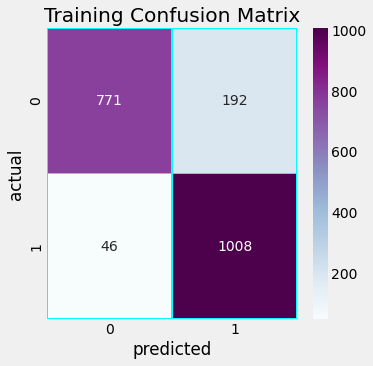

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
# proba = modelMI.predict(miX_train)
proba = (modelMI.predict_proba(miX_train)[:,1] >= 0.5).astype(bool) 

acc_score = accuracy_score(Y_train, proba)
cm = confusion_matrix(Y_train, proba)
print("*** Training Metrics ***")
print(f"Accuracy Score: {acc_score:.4f}")

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('Training Confusion Matrix')
plt.xlabel('predicted', )
plt.ylabel('actual')
plt.show()

In [ ]:
# X_valid_saved = copy.deepcopy(X_valid)
X_valid_saved.shape

(800, 42)

#####(3) Validation Metrics

*** Validation Metrics ***
Accuracy Score: 0.5100


Text(0.5, 1.0, 'Validation Confusion Matrix')

Text(0.5, 3.6999999999999815, 'predicted')

Text(7.300000000000001, 0.5, 'actual')

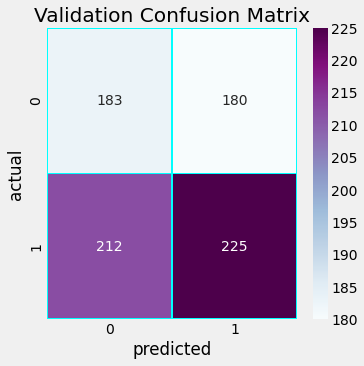

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_valid = copy.deepcopy(X_valid_saved)
# proba = modelMI.predict(miX_valid)
proba = (modelMI.predict_proba(miX_valid)[:,1] >= 0.5).astype(bool) 
X_valid['signal'] = proba

acc_score = accuracy_score(Y_valid, proba)
cm = confusion_matrix(Y_valid, proba)
print("*** Validation Metrics ***")
print(f"Accuracy Score: {acc_score:.4f}")

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('Validation Confusion Matrix')
plt.xlabel('predicted', )
plt.ylabel('actual')
plt.show()

#####(4) Net Average Returns & Sharpe Ratio on Testing Dataset (Dimensionality Reduction)

In [ ]:
X_valid["ROC"] = np.log(X_valid["Adj Close"] / X_valid["Adj Close"].shift(1))
X_valid["return"] = X_valid["ROC"]*X_valid["signal"]
X_valid["portfolio"] = np.exp(X_valid["return"].cumsum())
X_valid.dropna(inplace=True)
duration_days = X_valid.index.max()-X_valid.index.min()
duration_years = duration_days.days/365.25
duration_percentage = X_valid["signal"].mean()
duration_in_trade = duration_years * duration_percentage

if (duration_in_trade!=0):
  net_avg_return = X_valid.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
  returns = X_valid[X_valid["return"]!=0]["return"]
  sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

print("*** Model Validation (Validation Set) ***")
print(f"Net Average Return: {net_avg_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Duration Percentage: {duration_percentage:.2f}")

X_valid = copy.deepcopy(X_valid_saved)

*** Model Validation (Validation Set) ***
Net Average Return: 0.16
Sharpe Ratio: 0.39
Duration Percentage: 0.51


#####(5) Buy & Hold Strategy Net Average Returns & Sharpe Ratio on Testing Dataset

In [ ]:
X_valid.loc[:, "ROC"] = np.log(X_valid.loc[:, "Adj Close"] / X_valid.loc[:, "Adj Close"].shift(1))
X_valid["return"] = X_valid["ROC"]
X_valid["portfolio"] = np.exp(X_valid["return"].cumsum())
X_valid.dropna(inplace=True)
duration_days = X_valid.index.max()-X_valid.index.min()
duration_years = duration_days.days/365.25
duration_percentage = 1
duration_in_trade = duration_years * duration_percentage

if (duration_in_trade!=0):
  net_avg_return = X_valid.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
  returns = X_valid[X_valid["return"]!=0]["return"]
  sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

print("*** Buy & Hold (Validation Set) ***")
print(f"Net Average Return: {net_avg_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Duration Percentage: {duration_percentage:.2f}")

X_valid = copy.deepcopy(X_valid_saved)

*** Buy & Hold (Validation Set) ***
Net Average Return: 0.13
Sharpe Ratio: 0.38
Duration Percentage: 1.00


### V. F-test based Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

f_selection = SelectKBest(f_classif, k=10)
f_selection.fit(rescaledX_train, Y_train)

SelectKBest()

In [ ]:
fX_train = f_selection.transform(rescaledX_train)
fX_valid = f_selection.transform(rescaledX_valid)

In [ ]:
rescaledX_train.columns[f_selection.get_support()]

Index(['ROC_35', 'ROC_40', 'ROC_45', 'ROC_50', 'MACD_SIGNAL_26_12_9',
       'MACD_52_24_18', 'TRIX_20', 'AROON_20', 'AROON_30', 'AROON_40'],
      dtype='object')

In [ ]:
fX_train = pd.DataFrame(fX_train, columns=rescaledX_train.columns[f_selection.get_support()], index=rescaledX_train.index)
fX_valid = pd.DataFrame(fX_valid, columns=rescaledX_train.columns[f_selection.get_support()], index=rescaledX_valid.index)
print(fX_train.shape)
fX_train.head()

(2017, 10)


,ROC_35,ROC_40,ROC_45,ROC_50,MACD_SIGNAL_26_12_9,MACD_52_24_18,TRIX_20,AROON_20,AROON_30,AROON_40
Date,,,,,,,,,,
2011-03-16,-1.081723,-0.940795,-1.651110,-2.199733,-0.752334,-1.519069,-1.699169,-0.623173,0.012414,-0.80004
2011-03-17,-1.027291,-0.748004,-1.074534,-2.088747,-0.696522,-1.466818,-1.606096,-0.623173,0.012414,-0.80004
2011-03-18,-1.063028,-1.158201,-1.243067,-2.236437,-0.657261,-1.444587,-1.522782,-0.623173,0.012414,-0.80004
2011-03-21,-1.040974,-1.288027,-1.762447,-2.274773,-0.646025,-1.452566,-1.457507,0.195734,0.012414,-0.80004
2011-03-22,-0.772518,-1.376305,-1.482805,-2.222561,-0.654175,-1.460249,-1.407523,0.195734,0.012414,-0.80004


Time Without Dimensionality Reduction

In [ ]:
import time

# spot check the algorithms
# models =  LogisticRegression()
models = RandomForestClassifier(random_state=42, n_jobs=-1)

start_time = time.time()
cv_results_XTrain= cross_val_score(models, rescaledX_train, Y_train, cv=10, scoring="accuracy")
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time Without Dimensionality Reduction--- 10.156294345855713 seconds ---


Time With Dimensionality Reduction

In [ ]:
start_time = time.time()
cv_results_F = cross_val_score(models, fX_train, Y_train, cv=10, scoring="accuracy")
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time with Dimensionality Reduction--- 8.184985637664795 seconds ---


In [ ]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_F.mean(), cv_results_F.std()))

Result without dimensionality Reduction: 0.467098 (0.040666)
Result with dimensionality Reduction: 0.436375 (0.048208)


#####(1). Model Creation

In [ ]:
# from sklearn.model_selection import KFold, GridSearchCV

# penalty = ['l1', 'l2', 'none']
# C = np.logspace(-4, 4, 9)
# fit_intercept = [True, False]
# param_grid = dict(penalty=penalty, C=C, fit_intercept=fit_intercept)
# gsmodel = LogisticRegression(solver='saga', random_state=42)
# kfold = KFold(n_splits=5)
# grid = GridSearchCV(estimator=gsmodel, param_grid=param_grid, scoring="accuracy", cv=kfold)
# grid_result = grid.fit(fX_train, Y_train)

# #Print Results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# ranks = grid_result.cv_results_['rank_test_score']
# # for mean, stdev, param, rank in zip(means, stds, params, ranks):
# #     print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

In [ ]:
# modelF = LogisticRegression(C = grid_result.best_params_['C'], 
#                             fit_intercept = grid_result.best_params_['fit_intercept'], 
#                             solver = 'saga'
#                             )
# modelF.fit(fX_train, Y_train)

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

n_estimators = [10, 20, 30, 40, 50]
max_depth = [5, 6, 7, 8, 9, 10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
gsmodel = RandomForestClassifier(random_state=42, n_jobs=-1)
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
grid = GridSearchCV(estimator=gsmodel, param_grid=param_grid, scoring="accuracy", cv=kfold)
grid_result = grid.fit(fX_train, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
# for mean, stdev, param, rank in zip(means, stds, params, ranks):
#     print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.544878 using {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 20}


In [ ]:
modelF = RandomForestClassifier(criterion = grid_result.best_params_['criterion'], 
                              n_estimators = grid_result.best_params_['n_estimators'], 
                              max_depth = grid_result.best_params_['max_depth'], random_state=42)
modelF.fit(fX_train, Y_train)

RandomForestClassifier(max_depth=8, n_estimators=20, random_state=42)

#####(2) Training Metrics

*** Training Metrics ***
Accuracy Score: 0.8027


Text(0.5, 1.0, 'Training Confusion Matrix')

Text(0.5, 3.6999999999999815, 'predicted')

Text(7.300000000000001, 0.5, 'actual')

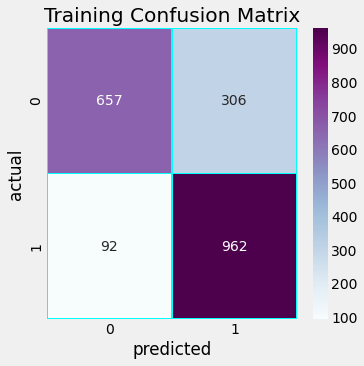

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
# proba = modelF.predict(fX_train)
proba = (modelF.predict_proba(fX_train)[:,1] >= 0.5).astype(bool) 

acc_score = accuracy_score(Y_train, proba)
cm = confusion_matrix(Y_train, proba)
print("*** Training Metrics ***")
print(f"Accuracy Score: {acc_score:.4f}")

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('Training Confusion Matrix')
plt.xlabel('predicted', )
plt.ylabel('actual')
plt.show()

In [ ]:
# X_valid_saved = copy.deepcopy(X_valid)
X_valid_saved.shape

(800, 42)

#####(3) Validation Metrics

*** Validation Metrics ***
Accuracy Score: 0.4775


Text(0.5, 1.0, 'Validation Confusion Matrix')

Text(0.5, 3.6999999999999815, 'predicted')

Text(7.300000000000001, 0.5, 'actual')

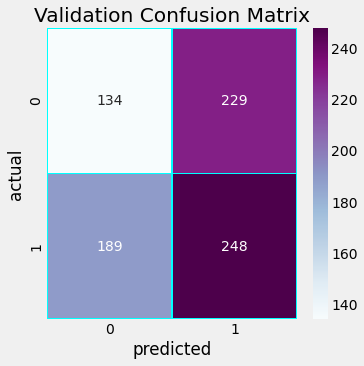

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_valid = copy.deepcopy(X_valid_saved)
# proba = modelF.predict(fX_valid)
proba = (modelF.predict_proba(fX_valid)[:,1] >= 0.5).astype(bool) 
X_valid['signal'] = proba

acc_score = accuracy_score(Y_valid, proba)
cm = confusion_matrix(Y_valid, proba)
print("*** Validation Metrics ***")
print(f"Accuracy Score: {acc_score:.4f}")

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('Validation Confusion Matrix')
plt.xlabel('predicted', )
plt.ylabel('actual')
plt.show()

#####(4) Net Average Returns & Sharpe Ratio on Testing Dataset (Dimensionality Reduction)

In [ ]:
X_valid["ROC"] = np.log(X_valid["Adj Close"] / X_valid["Adj Close"].shift(1))
X_valid["return"] = X_valid["ROC"]*X_valid["signal"]
X_valid["portfolio"] = np.exp(X_valid["return"].cumsum())
X_valid.dropna(inplace=True)
duration_days = X_valid.index.max()-X_valid.index.min()
duration_years = duration_days.days/365.25
duration_percentage = X_valid["signal"].mean()
duration_in_trade = duration_years * duration_percentage

if (duration_in_trade!=0):
  net_avg_return = X_valid.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
  returns = X_valid[X_valid["return"]!=0]["return"]
  sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

print("*** Model Validation (Validation Set) ***")
print(f"Net Average Return: {net_avg_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Duration Percentage: {duration_percentage:.2f}")

X_valid = copy.deepcopy(X_valid_saved)

*** Model Validation (Validation Set) ***
Net Average Return: -0.10
Sharpe Ratio: -0.59
Duration Percentage: 0.60


#####(5) Buy & Hold Strategy Net Average Returns & Sharpe Ratio on Testing Dataset

In [ ]:
X_valid.loc[:, "ROC"] = np.log(X_valid.loc[:, "Adj Close"] / X_valid.loc[:, "Adj Close"].shift(1))
X_valid["return"] = X_valid["ROC"]
X_valid["portfolio"] = np.exp(X_valid["return"].cumsum())
X_valid.dropna(inplace=True)
duration_days = X_valid.index.max()-X_valid.index.min()
duration_years = duration_days.days/365.25
duration_percentage = 1
duration_in_trade = duration_years * duration_percentage

if (duration_in_trade!=0):
  net_avg_return = X_valid.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
  returns = X_valid[X_valid["return"]!=0]["return"]
  sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

print("*** Buy & Hold (Validation Set) ***")
print(f"Net Average Return: {net_avg_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Duration Percentage: {duration_percentage:.2f}")

X_valid = copy.deepcopy(X_valid_saved)

*** Buy & Hold (Validation Set) ***
Net Average Return: 0.13
Sharpe Ratio: 0.38
Duration Percentage: 1.00


#D. Determining Optimal Threshold/Cut-off of the Model for greater Accuracy (Cohen's Kappa Score)

In [ ]:
# from sklearn.model_selection import train_test_split, cross_val_score
# X = df.drop(['target'], axis=1)
# Y = df["target"]

# # X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_train, X_valid, Y_train, Y_valid = X[:-800], X[-800:], Y[:-800], Y[-800:]
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(X_train.drop("Adj Close", axis=1))
# rescaledX_train = pd.DataFrame(scaler.transform(X_train.drop("Adj Close", axis=1)), columns=X_train.drop("Adj Close", axis=1).columns, index=X_train.index)
# rescaledX_valid = pd.DataFrame(scaler.transform(X_valid.drop("Adj Close", axis=1)), columns=X_valid.drop("Adj Close", axis=1).columns, index=X_valid.index)

# svdX_train = svd.fit_transform(rescaledX_train)

In [ ]:
# model_ = model
# X_ = rescaledX_train
# Y_ = Y_train

In [ ]:
# model_ = modelSVD
# X_ = svdX_train
# Y_ = Y_train

### (1) Skopt Method

In [ ]:
# from functools import partial
# from skopt import gp_minimize
# from skopt import space
# import sys
# from sklearn.metrics import recall_score, balanced_accuracy_score, f1_score, cohen_kappa_score

# def error(threshold):
#   proba = (model_.predict_proba(X_)[:,1] >= threshold).astype(bool)
#   return -cohen_kappa_score(Y_, proba)

# def optimize(params, param_names):
#   params = dict(zip(param_names, params))
#   threshold = params["threshold"]
#   return error(threshold)

# param_space =[
#               space.Real(0.01, 0.5, name="threshold")
# ]

# param_names = [
#                "threshold"
# ]

# optimization_function = partial(
#     optimize,
#     param_names=param_names
# )

# result = gp_minimize(
#     optimization_function,
#     dimensions=param_space,
#     n_calls=150,
#     n_random_starts=10,
#     verbose=0,
#     random_state=42
# )

# best_params = dict(
#     zip(
#         param_names,
#         result.x
#     )
# )

# print(best_params)

### (2) Hyperopt Method

In [ ]:
# from functools import partial
# from hyperopt import hp, fmin, tpe, Trials
# from hyperopt.pyll.base import scope

# def error(threshold):
#   proba = (model_.predict_proba(X_)[:,1] >= threshold).astype(bool) 
#   return -cohen_kappa_score(Y_, proba)

# def optimize(params):
#   threshold = params["threshold"]
#   return error(threshold)

# param_space ={
#               "threshold": hp.uniform("threshold", 0.01, 0.5)
# }

# optimization_function = partial(
#     optimize
# )

# trials = Trials()
# rstate = np.random.RandomState(42)

# hopt = fmin(
#     fn=optimization_function,
#     space=param_space,
#     algo=tpe.suggest,
#     max_evals=150,
#     trials=trials,
#     rstate=rstate
# )

# print(hopt)

### (3) Optima Method

In [ ]:
# from functools import partial
# import optuna
# from optuna.samplers import TPESampler

# def error(threshold):
#   proba = (model_.predict_proba(X_)[:,1] >= threshold).astype(bool) 
#   return -cohen_kappa_score(Y_, proba)

# def optimize(trial):
#   threshold = trial.suggest_uniform("threshold", 0.01, 0.5)
#   return error(threshold)

# optimization_function = partial(
#     optimize
# )

# sampler = TPESampler(seed=42)
# study = optuna.create_study(sampler=sampler, direction="minimize")
# study.optimize(optimization_function, n_trials=150)

# print(study.best_params)